In [1]:
!python -m pip install visualkeras

In [7]:
import plotly.offline as pyo
from tqdm import tqdm
pyo.init_notebook_mode()
import numpy as np
from numpy import expand_dims
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import cv2 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import statsmodels.api as sm
from sklearn import preprocessing
import random
import tensorflow as tf

from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [3]:
def Create_Directory_DataFrame():
    df = pd.DataFrame(columns=['Class', 'Location'])
    basedir = './Datasets/leapGestRecog/'
    
    for folder in os.listdir(basedir):
        for Class in os.listdir(os.path.join(basedir, folder)):
            for location in os.listdir(os.path.join(basedir, folder, Class)):
                df = pd.concat([df, pd.DataFrame({'Class': [Class], 'Location': [os.path.join(basedir, folder, Class, location)]})], ignore_index=True)
    
    df = df.sample(frac=1).reset_index(drop=True)
    return df


In [4]:
df = Create_Directory_DataFrame()
print(df.shape)
df.head()

(20000, 2)


Class                                           Location
0  08_palm_moved  ./Datasets/leapGestRecog/02\08_palm_moved\fram...
1          07_ok  ./Datasets/leapGestRecog/01\07_ok\frame_01_07_...
2  08_palm_moved  ./Datasets/leapGestRecog/07\08_palm_moved\fram...
3          07_ok  ./Datasets/leapGestRecog/07\07_ok\frame_07_07_...
4       05_thumb  ./Datasets/leapGestRecog/03\05_thumb\frame_03_...

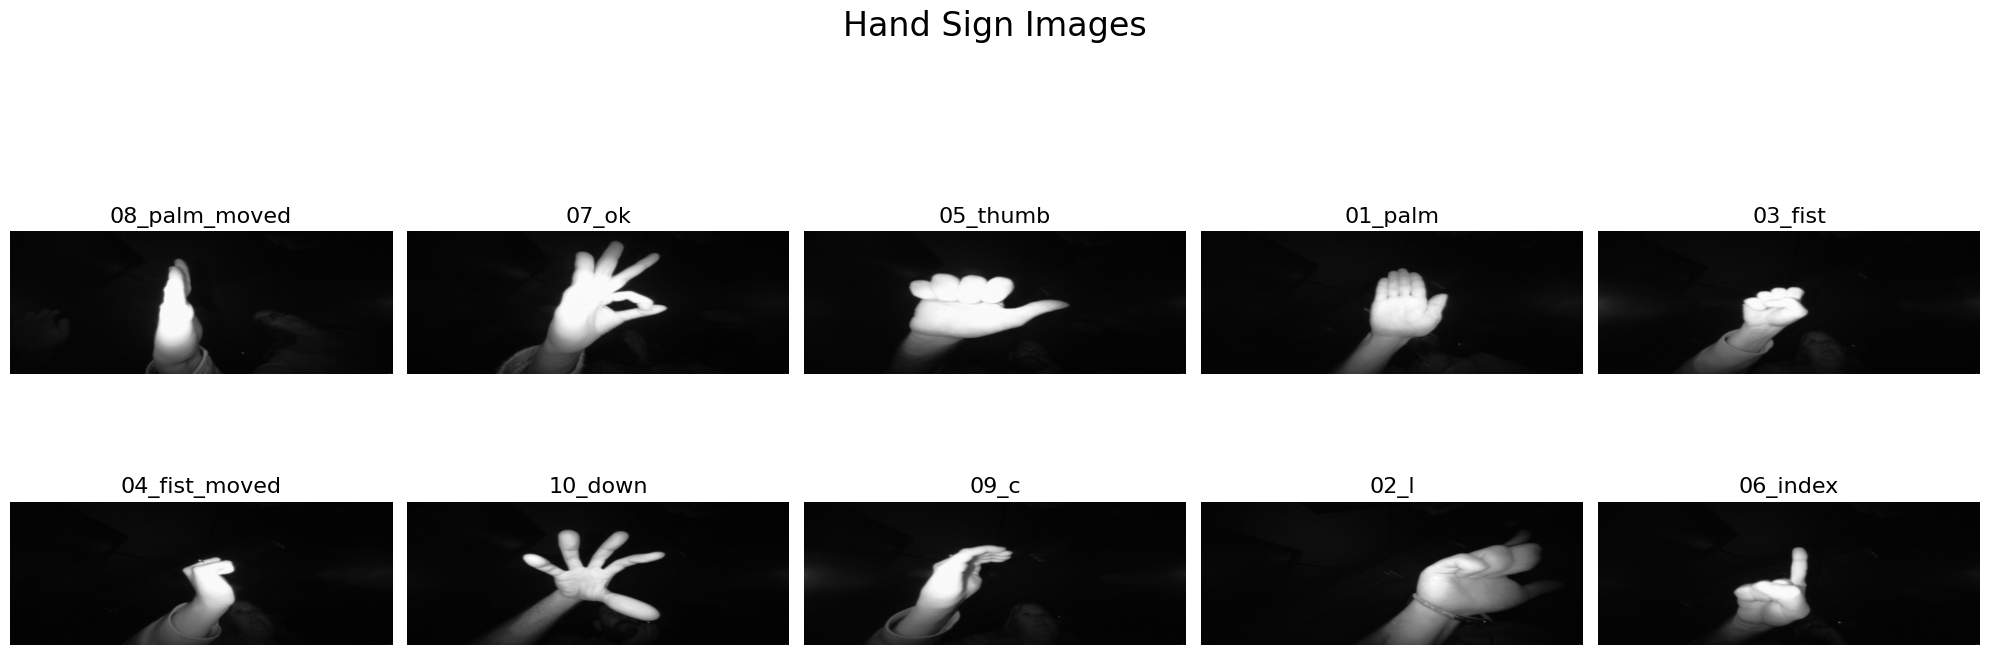

In [5]:
unique_classes = df['Class'].unique()
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
fig.suptitle("Hand Sign Images", size=24)

axes = axes.flatten()

for i, current_class in enumerate(unique_classes):
    subset = df[df['Class'] == current_class]
    sample_row = subset.sample().iloc[0]
    image_path = sample_row['Location']

    img = cv2.imread(image_path, 0)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(current_class, fontsize=16)
    axes[i].axis('off')  # Turn off axis labels
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


In [6]:
img.shape

(240, 640)

In [7]:
w , h= 64,64
final_class = 10

In [8]:
# Read and preprocess images
train_image = [cv2.resize(cv2.imread(location, 0), (w, h), interpolation=cv2.INTER_AREA).reshape(w, h, 1) / 255.0
               for location in tqdm(df['Location'])]

# Convert the list to a NumPy array
X = np.array(train_image)

  0%|          | 4/20000 [00:00<10:17, 32.36it/s]

100%|██████████| 20000/20000 [06:01<00:00, 55.29it/s]


In [9]:
y = df['Class'].values.reshape(-1, 1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y)

print(enc.categories_)


[array(['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
       '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'],
      dtype=object)]


In [10]:
y = enc.transform(y).toarray()

In [11]:
print('Data   :   '+str(X.shape))
print('Output :   '+str(y.shape))

Data   :   (20000, 64, 64, 1)
Output :   (20000, 10)


In [12]:
print(X[0].reshape(w,h))

[[0.01960784 0.01960784 0.01960784 ... 0.01568627 0.01568627 0.01568627]
 [0.01568627 0.01960784 0.01568627 ... 0.01568627 0.01176471 0.01176471]
 [0.01960784 0.01960784 0.01960784 ... 0.01568627 0.01568627 0.01568627]
 ...
 [0.01568627 0.01568627 0.01960784 ... 0.01568627 0.01568627 0.01568627]
 [0.01960784 0.01960784 0.01960784 ... 0.01568627 0.01568627 0.01568627]
 [0.01568627 0.01960784 0.01960784 ... 0.01568627 0.01568627 0.03137255]]


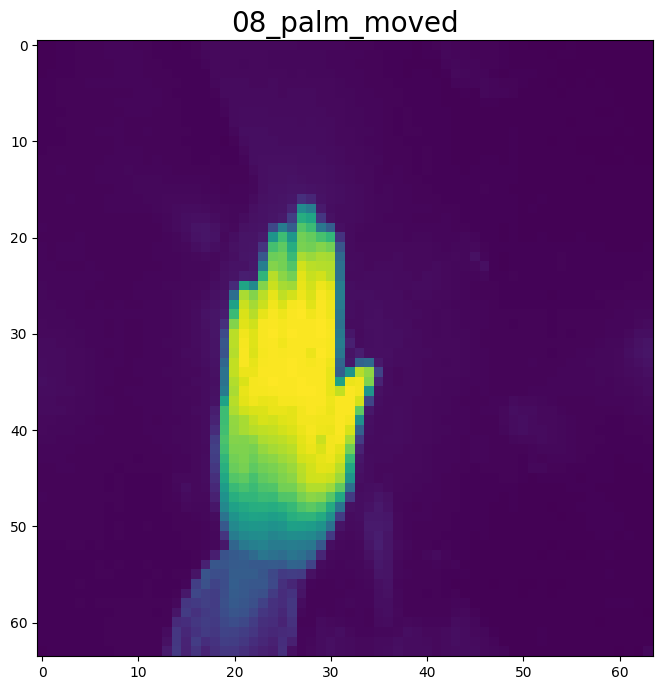

In [13]:
plt.figure(figsize=(25,8))
plt.imshow(X[66].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

In [14]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [16]:
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(18000, 64, 64, 1)
Test data     :(2000, 64, 64, 1)
Train Output  :(18000, 10)
Test Output   :(2000, 10)


In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

def build_model(act, final_class, w, h):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(w, h, 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),  # Increased dropout rate
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),  # Increased dropout rate
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),  # Increased dropout rate
        dense_block(128, 0.4),  # Increased dropout rate
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(final_class, activation='sigmoid')
    ])
    return model


In [18]:
def wrap(output_results, optimizer, activation, history):
    """
    Appends training history results to the output DataFrame.

    Parameters:
    - output_results (pd.DataFrame): Existing DataFrame to which results will be appended.
    - optimizer (str): Optimizer used during training.
    - activation (str): Activation function used in the model.
    - history (tf.keras.callbacks.History): Training history.

    Returns:
    pd.DataFrame: Updated DataFrame containing appended results.
    """
    epochs = np.arange(1, len(history.history['loss']) + 1, 1)
    optimizer_list = np.repeat(optimizer, len(epochs)).tolist()
    activation_list = np.repeat(activation, len(epochs)).tolist()

    cumulative_res = {
        'Epochs': epochs,
        'Optimizer': optimizer_list,
        'Activation_Function': activation_list,
        'Train_Loss': history.history['loss'],
        'Train_Accuracy': history.history['accuracy'],
        'Train_Precision': history.history['precision'],
        'Train_Recall': history.history['recall'],
        'Val_Loss': history.history['val_loss'],
        'Val_Accuracy': history.history['val_accuracy'],
        'Val_Precision': history.history['val_precision'],
        'Val_Recall': history.history['val_recall']
    }

    result_df = pd.DataFrame(cumulative_res)

    # Ensure that output_results is a DataFrame
    if not isinstance(output_results, pd.DataFrame):
        output_results = pd.DataFrame(columns=result_df.columns)

    output_results = pd.concat([output_results, result_df], ignore_index=True)
    return output_results


In [19]:
Optimisers = ['RMSprop','Adam','Adadelta','Adagrad']
Activation_function =['relu','sigmoid','softmax','tanh','softsign','selu','elu']

In [20]:
Training_Output_Results =pd.DataFrame(columns=['Epochs','Optimizer','Activation_Function','Train_Loss','Train_Accuracy','Train_Precision','Train_Recall','Val_Loss','Val_Accuracy','Val_Precision','Val_Recall'])


In [21]:
def Optimise_verify(Training_Output_Results):
    for opt in Optimisers:
        model = build_model(Activation_function[0], final_class , w , h)
        METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
        ]  
        model.compile(
                optimizer=opt,
                loss='categorical_crossentropy',
                metrics=METRICS
            )
        history = model.fit(X_train, y_train, epochs=10, validation_split=0.3, batch_size=15,verbose=0,shuffle=True)
        Training_Output_Results = wrap(Training_Output_Results , opt,Activation_function[0],history)
        print('---------------------Round for '+opt+' Completed-----------------------------------------')
    return Training_Output_Results
    


In [22]:
    
Training_Output_Results = Optimise_verify(Training_Output_Results)







---------------------Round for RMSprop Completed-----------------------------------------
---------------------Round for Adam Completed-----------------------------------------
---------------------Round for Adadelta Completed-----------------------------------------
---------------------Round for Adagrad Completed-----------------------------------------


In [23]:
Training_Output_Results=Training_Output_Results.sample(frac = 1) 
print(Training_Output_Results.shape)
Training_Output_Results.to_csv('Optimizer_64X64_data.csv', index = False) 
Training_Output_Results.head()

(40, 11)


Epochs Optimizer Activation_Function  Train_Loss  Train_Accuracy  \
25      6  Adadelta                relu    2.923186        0.141032   
27      8  Adadelta                relu    2.827627        0.152937   
8       9   RMSprop                relu    0.048463        0.987936   
11      2      Adam                relu    0.297885        0.912143   
29     10  Adadelta                relu    2.747782        0.168016   

    Train_Precision  Train_Recall  Val_Loss  Val_Accuracy  Val_Precision  \
25         0.115600      0.578889  2.082665      0.265926       0.173516   
27         0.119894      0.599841  1.979638      0.313333       0.172344   
8          0.279465      0.999286  0.037104      0.994444       0.353643   
11         0.233271      0.997381  0.182938      0.931481       0.250093   
29         0.124703      0.624683  1.954958      0.347778       0.158485   

    Val_Recall  
25    0.612963  
27    0.713889  
8     0.999630  
11    0.998889  
29    0.761667

In [24]:
Training_Output_Results =pd.DataFrame(columns=['Epochs','Optimizer','Activation_Function','Train_Loss','Train_Accuracy','Train_Precision','Train_Recall',
                                              'Val_Loss','Val_Accuracy','Val_Precision','Val_Recall'])


In [25]:
def Activation_verify(Training_Output_Results):
    for act in Activation_function:
        model = build_model(act,final_class,w,h)
        METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
        ]  
        model.compile(
                optimizer=Optimisers[0],
                loss='categorical_crossentropy',
                metrics=METRICS
            )
        history = model.fit(X_train, y_train, epochs=10, validation_split=0.3, batch_size=15,verbose=0,shuffle=True)
        Training_Output_Results = wrap(Training_Output_Results , Optimisers[0],act,history)
        print('---------------------Round for '+act+' Completed-----------------------------------------')
    return Training_Output_Results
    
    


In [26]:
Training_Output_Results = Activation_verify(Training_Output_Results)

---------------------Round for relu Completed-----------------------------------------
---------------------Round for sigmoid Completed-----------------------------------------
---------------------Round for softmax Completed-----------------------------------------
---------------------Round for tanh Completed-----------------------------------------
---------------------Round for softsign Completed-----------------------------------------
---------------------Round for selu Completed-----------------------------------------
---------------------Round for elu Completed-----------------------------------------


In [27]:
Training_Output_Results=Training_Output_Results.sample(frac = 1) 
print(Training_Output_Results.shape)

Training_Output_Results.to_csv('Activation_64X64_data.csv', index = False)
Training_Output_Results.head()

(70, 11)


Epochs Optimizer Activation_Function  Train_Loss  Train_Accuracy  \
42      3   RMSprop            softsign    0.130220        0.962381   
0       1   RMSprop                relu    1.372123        0.536190   
15      6   RMSprop             sigmoid    0.085875        0.976349   
58      9   RMSprop                selu    0.047955        0.989127   
45      6   RMSprop            softsign    0.057616        0.984206   

    Train_Precision  Train_Recall  Val_Loss  Val_Accuracy  Val_Precision  \
42         0.255912      0.998889  0.029712      0.991852       0.287601   
0          0.192881      0.888889  0.484912      0.814630       0.241834   
15         0.269167      0.999444  0.395345      0.905000       0.323449   
58         0.280373      0.999286  0.120936      0.967222       0.308938   
45         0.274932      0.999444  0.015127      0.998333       0.373495   

    Val_Recall  
42    1.000000  
0     0.999444  
15    0.991852  
58    0.999815  
45    0.999444

In [28]:
opt = pd.read_csv('./Optimizer_64X64_data.csv')
act = pd.read_csv('./Activation_64X64_data.csv')

In [29]:

scatterplot = px.area(
    data_frame=opt,  
    x="Epochs",
    y="Train_Accuracy",
    color="Optimizer",
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],
    title='Train Accuracy',
    # width=500,
    # height=500,
    template='presentation',
)

pio.show(scatterplot, filename='Opt_train_acc.html')


In [30]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Train_Loss",
    color="Optimizer",                                              
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],
    title='Train Loss',           
    #width=500,                  
    #height=500,                
    template='presentation',     
)
pyo.iplot(scatterplot, filename = 'Opt_train_loss')

In [31]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Train_Precision",
    color="Optimizer",                                            
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],
    title='Train Precision',
    #width=500,             
    #height=500,            
    template='presentation',
)
pyo.iplot(scatterplot, filename = 'Opt_train_prec')

In [32]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Train_Recall",
    color="Optimizer",                                             
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],
    title='Train Recall',
    #width=500,          
    #height=500,         
    template='presentation',
)
pyo.iplot(scatterplot, filename = 'Opt_train_recall')

In [33]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Val_Accuracy",
    color="Optimizer",                                              
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],
    facet_col='Optimizer',      
    facet_col_wrap=2,
    title='Validation Accuracy',
    #width=500,                 
    #height=500,                
    template='presentation',    
)
pyo.iplot(scatterplot, filename = 'Opt_val_acc')

In [34]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Val_Precision",
    color="Optimizer",                                              
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],   
    facet_col='Optimizer',      
    facet_col_wrap=2,           
    title='Validation Precision',          
    #width=500,                  
    #height=500,                
    template='presentation',    
)
pyo.iplot(scatterplot, filename = 'Opt_val_prec')

In [35]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Val_Recall",
    color="Optimizer",                                              
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],   
    facet_col='Optimizer',      
    facet_col_wrap=2,           
    title='Validation Recall',  
    #width=500,                 
    #height=500,                
    template='presentation',     
)
pyo.iplot(scatterplot, filename = 'Opt_val_recall')

In [36]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Val_Loss",
    color="Optimizer",                                              
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],   
    title='Validation Loss',
    template='presentation',   
)
pyo.iplot(scatterplot, filename = 'Opt_val_loss')

# Activation Function

In [37]:

scatterplot = px.area(
    data_frame=act,
    x="Epochs",
    y="Train_Accuracy",
    color="Activation_Function",                                              
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],   
    title='Train Accuracy',
    template='presentation',
)
pyo.iplot(scatterplot, filename = 'Act_train_acc')

In [38]:
scatterplot = px.area(
    data_frame=act,
    x="Epochs",
    y="Train_Loss",
    color="Activation_Function",                                              
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],   
    title='Train Loss',
    template='presentation',     
)
pyo.iplot(scatterplot, filename = 'Act_train_loss')

In [39]:

scatterplot = px.area(
    data_frame=act,
    x="Epochs",
    y="Train_Precision",
    color="Activation_Function",
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],
    title='Train Precision',
    template='presentation',
)
pyo.iplot(scatterplot, filename = 'Act_train_prec')

In [40]:

scatterplot = px.area(
    data_frame=act,
    x="Epochs",
    y="Train_Recall",
    color="Activation_Function",                                            
    color_discrete_sequence=["#3a86ff", "#8338ec", "#ff006e", "#fb5607"],   
    title='Train Recall',
    template='presentation',
)
pyo.iplot(scatterplot, filename = 'Act_train_rec')

In [41]:

tab_opt = opt[opt['Epochs']==10]
final_col = np.delete(tab_opt.columns[0:], [0,2])
fig = go.Figure(data=[go.Table(
    header=dict(values=list(final_col),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[tab_opt.Optimizer , tab_opt.Train_Loss,tab_opt.Train_Accuracy,tab_opt.Train_Precision,tab_opt.Train_Recall,tab_opt.Val_Loss,tab_opt.Val_Accuracy,tab_opt.Val_Precision,tab_opt.Val_Recall],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [42]:

ty =opt[opt['Epochs']==10].iloc[:,3:]
nm = ty.columns
ty = ty.values.tolist()
data = []

for j in range(len(nm)):
        lt = []
        for i in range(len(Optimisers)):
            lt.append(ty[i][j])
            
        data.append(go.Bar(name = nm[j],x=Optimisers, y=lt))
fig = go.Figure(data=data)
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [43]:

tab_opt = act[act['Epochs']==10]
final_col = np.delete(tab_opt.columns[0:], [0,1])
fig = go.Figure(data=[go.Table(
    header=dict(values=list(final_col),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[tab_opt.Activation_Function , tab_opt.Train_Loss,tab_opt.Train_Accuracy,tab_opt.Train_Precision,tab_opt.Train_Recall,tab_opt.Val_Loss,tab_opt.Val_Accuracy,tab_opt.Val_Precision,tab_opt.Val_Recall],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [44]:
ty =act[act['Epochs']==10].iloc[:,3:]
nm = ty.columns
ty = ty.values.tolist()
data = []

for j in range(len(nm)):
        lt = []
        for i in range(len(Activation_function)):
            lt.append(ty[i][j])
            
        data.append(go.Bar(name = nm[j],x=Activation_function, y=lt))
fig = go.Figure(data=data)
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

# Final Model

In [45]:
def Plot(history , name , model):
    model.save(name+'.h5')
    epochs = range(1,len(history.history['loss']) + 1)
    epochs = list(epochs)
    fig = make_subplots(rows=2, cols=4,subplot_titles=("Train Loss", "Train Accuracy" , "Train Precision","Train Recall", "Validation Loss", "Validation Accuracy",
                                                      "Validation Precision","Validation Recall"))
    fig.add_trace(go.Scatter(x=epochs, y=history.history['loss']), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['accuracy']), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['precision']), row=1, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['recall']), row=1, col=4)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_loss']), row=2, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy']), row=2, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_precision']), row=2, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_recall']), row=2, col=4)
    fig.update_layout(showlegend=False,height=1000, width=1200, title_text=name)
    pyo.iplot(fig, filename = 'Act_train_rec')

object : the model to train.      
-> X : our training data. Can be Vector, array or matrix      
-> Y : our training labels. Can be Vector, array or matrix       
-> Batch_size : it can take any integer value or NULL and by default, it will
be set to 32. It specifies no. of samples per gradient.      
-> Epochs : an integer and number of epochs we want to train our model for.      
-> Verbose : specifies verbosity mode(0 = silent, 1= progress bar, 2 = one
line per epoch).      
-> Shuffle : whether we want to shuffle our training data before each epoch.      
-> steps_per_epoch : it specifies the total number of steps taken before
one epoch has finished and started the next epoch. By default it values is set to NULL.

In [46]:
model = build_model('relu', final_class ,w , h)
METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
]  
model.compile(
                optimizer='RMSprop',
                loss='categorical_crossentropy',
                metrics=METRICS
        )
history = model.fit(X_train, y_train, epochs=50, validation_split=0.3, batch_size=15,verbose=1,shuffle=True)

Epoch 1/50
840/840 [==============================] - 44s 48ms/step - loss: 1.4701 - accuracy: 0.5148 - precision: 0.1876 - recall: 0.8667 - val_loss: 2.6200 - val_accuracy: 0.4569 - val_precision: 0.2388 - val_recall: 0.7648
Epoch 2/50
840/840 [==============================] - 32s 39ms/step - loss: 0.2852 - accuracy: 0.9160 - precision: 0.2377 - recall: 0.9969 - val_loss: 0.0548 - val_accuracy: 0.9852 - val_precision: 0.2568 - val_recall: 0.9993
Epoch 3/50
840/840 [==============================] - 32s 39ms/step - loss: 0.1586 - accuracy: 0.9558 - precision: 0.2477 - recall: 0.9979 - val_loss: 0.0622 - val_accuracy: 0.9830 - val_precision: 0.2696 - val_recall: 1.0000
Epoch 4/50
840/840 [==============================] - 32s 38ms/step - loss: 0.1073 - accuracy: 0.9687 - precision: 0.2585 - recall: 0.9989 - val_loss: 0.0216 - val_accuracy: 0.9950 - val_precision: 0.3112 - val_recall: 0.9994
Epoch 5/50
840/840 [==============================] - 32s 38ms/step - loss: 0.0832 - accuracy: 0

In [47]:
Plot(history , 'final_model',model)

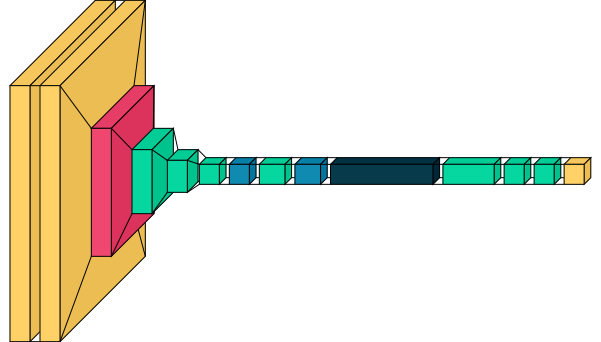

In [48]:
import visualkeras
visualkeras.layered_view(model)

In [49]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


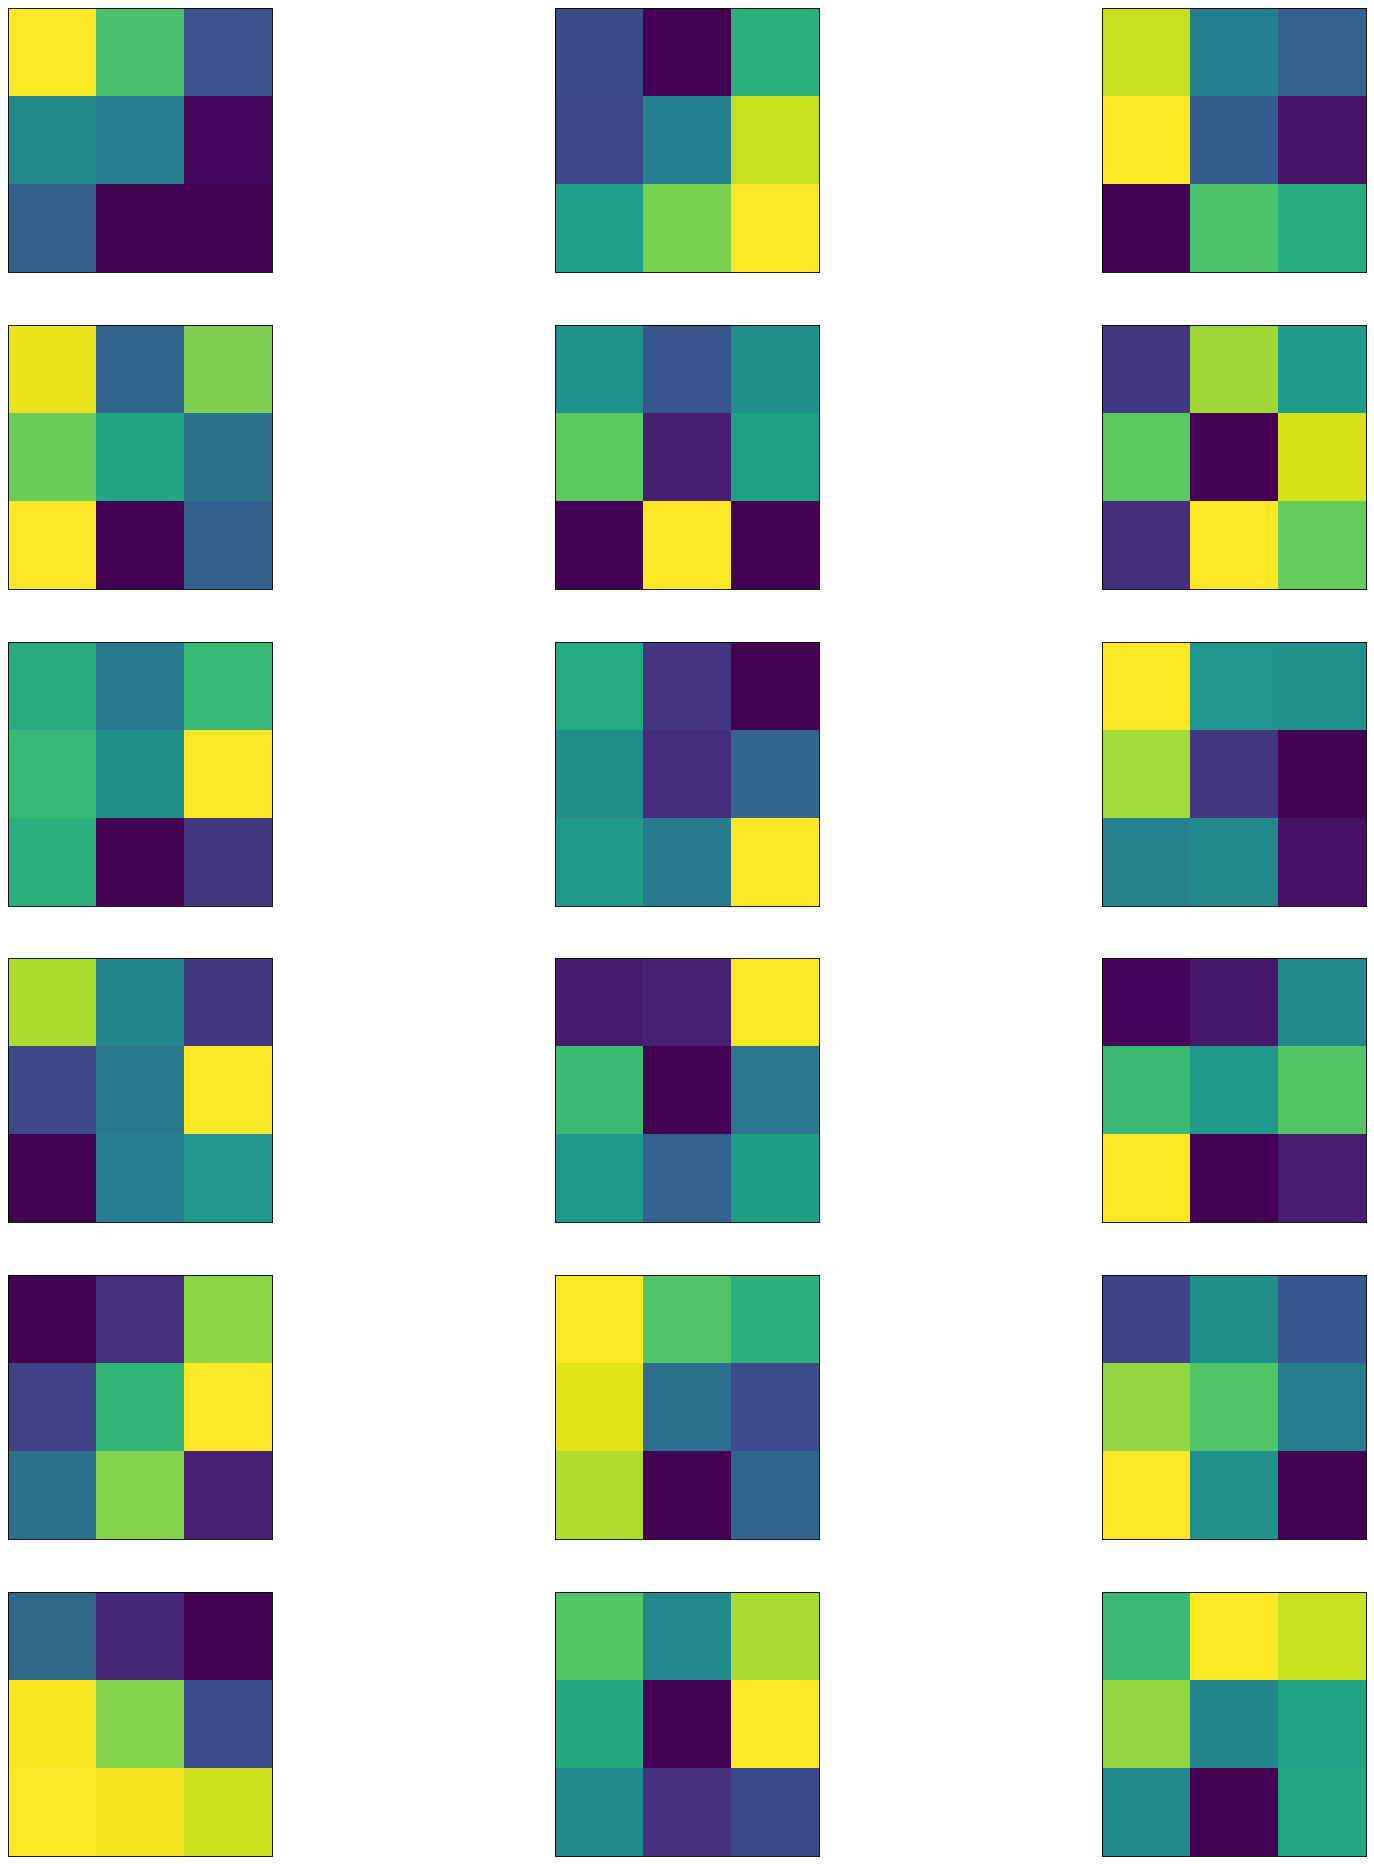

In [54]:
fig = plt.figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')

filters, biases = model.layers[1].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 6, 1

for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j])
        ix += 1

plt.show()


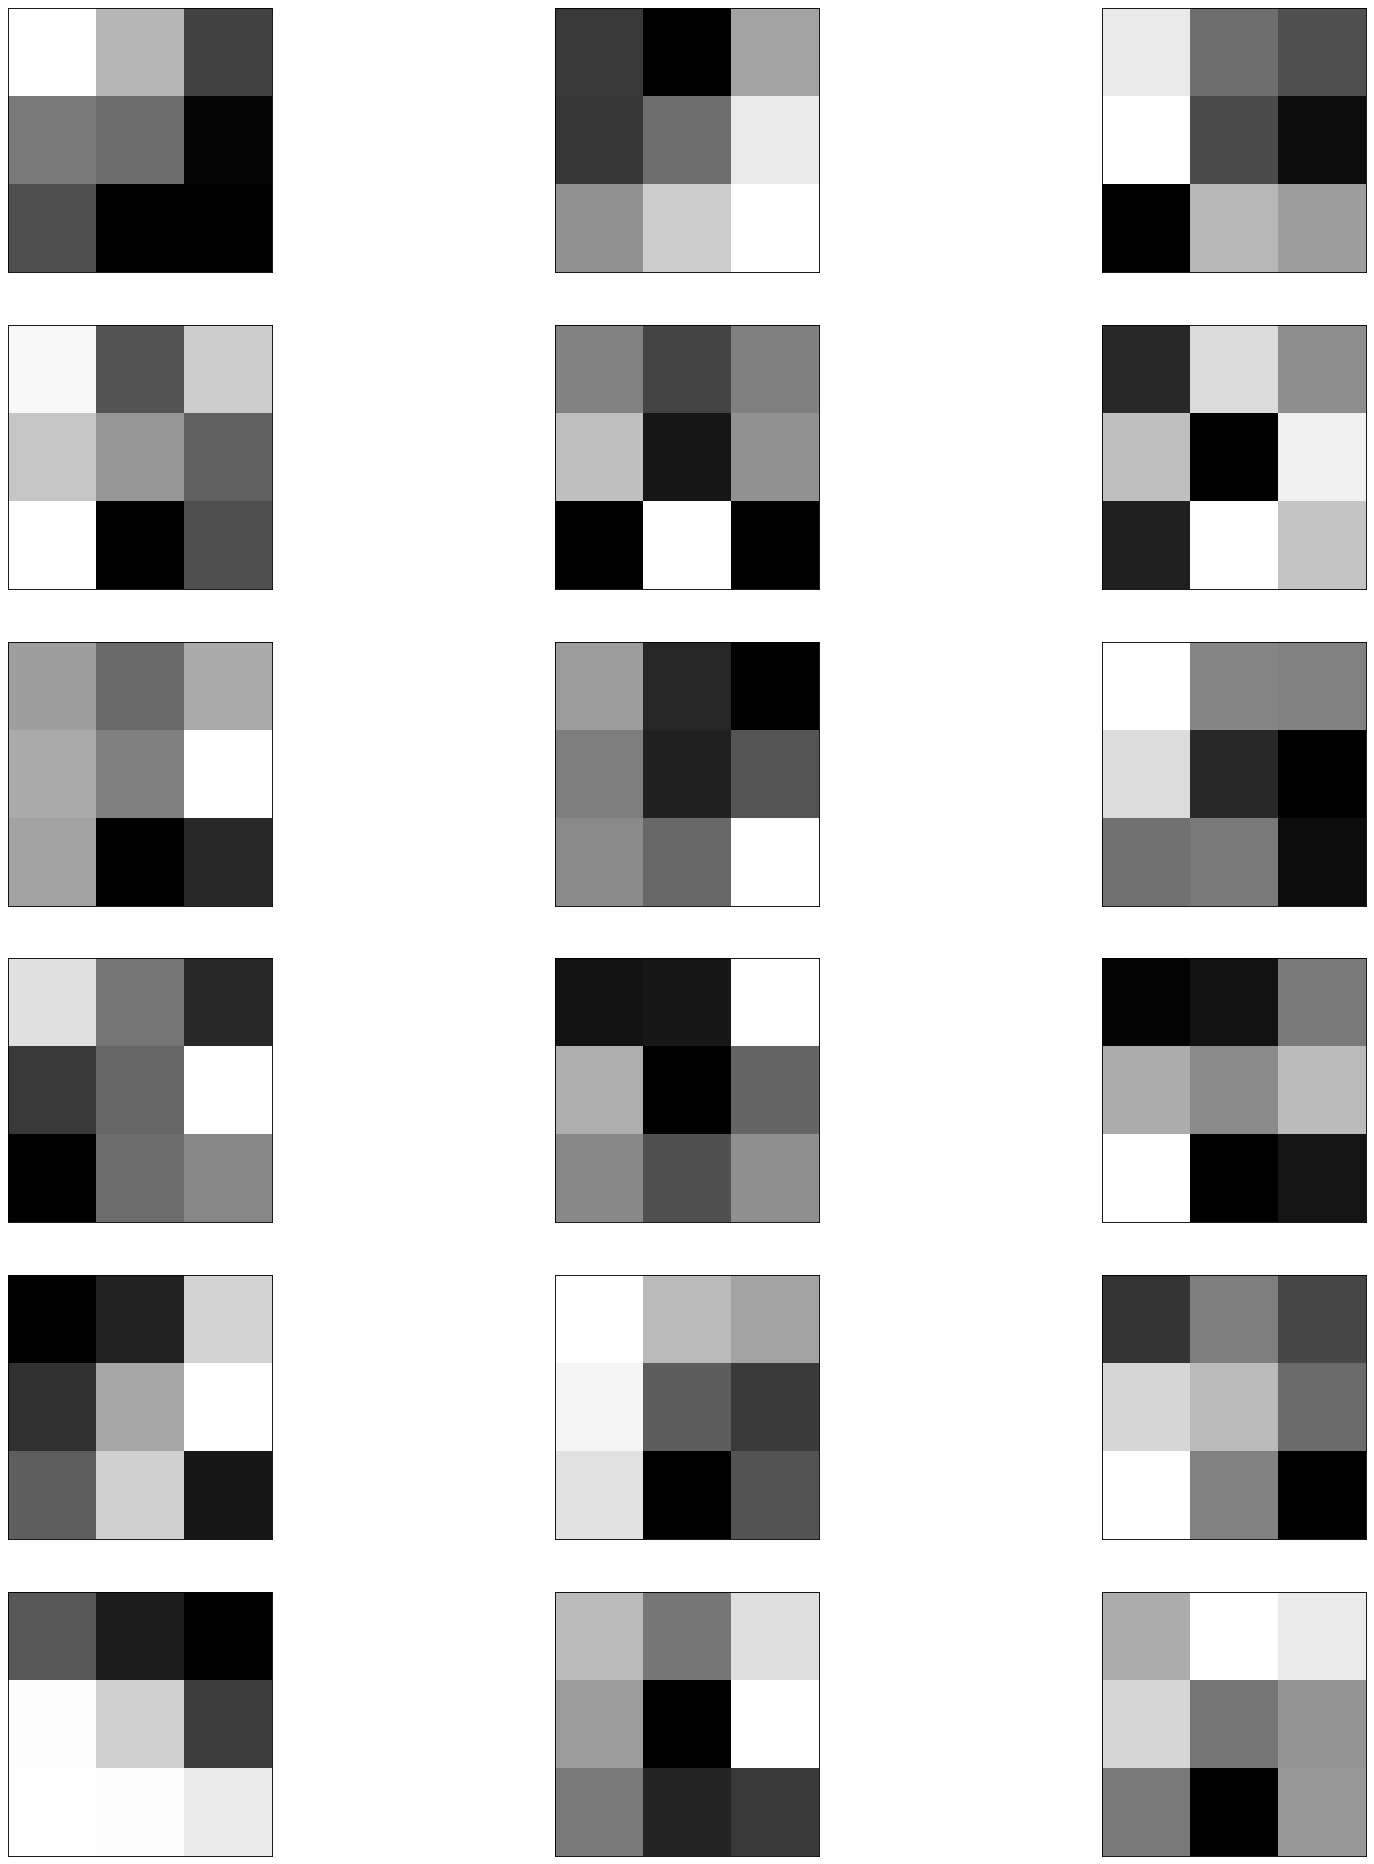

In [58]:

figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters,3 , ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j],cmap='gray')
		ix += 1
# show the figure
plt.show()

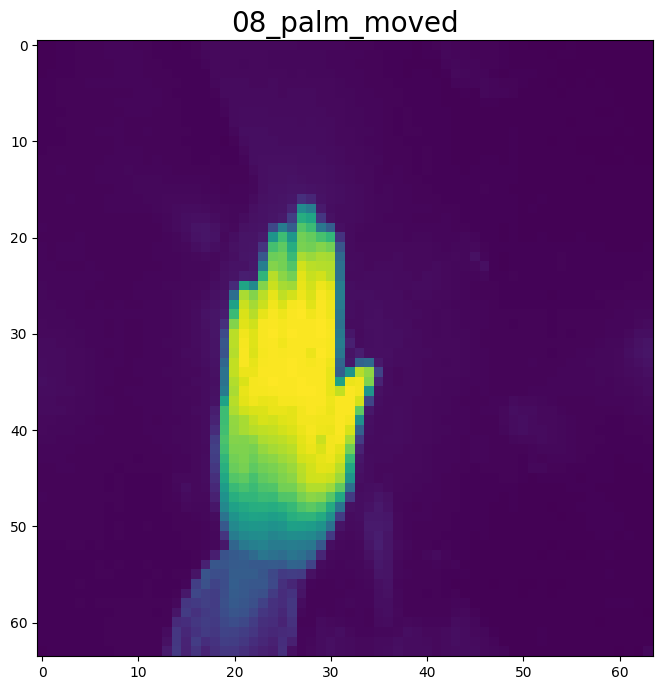

In [59]:
plt.figure(figsize=(25,8))
plt.imshow(X[66].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

In [61]:

def image_transform_gray(image):
    img = expand_dims(image, axis=0)
    model1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
    feature_maps = model1.predict(img)
    figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1],cmap='gray')
            ix += 1
    
    plt.show()
def image_transform(image):
    img = expand_dims(image, axis=0)
    model1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
    feature_maps = model1.predict(img)
    figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1])
            ix += 1
    plt.show()

1/1 [==============================] - 0s 108ms/step


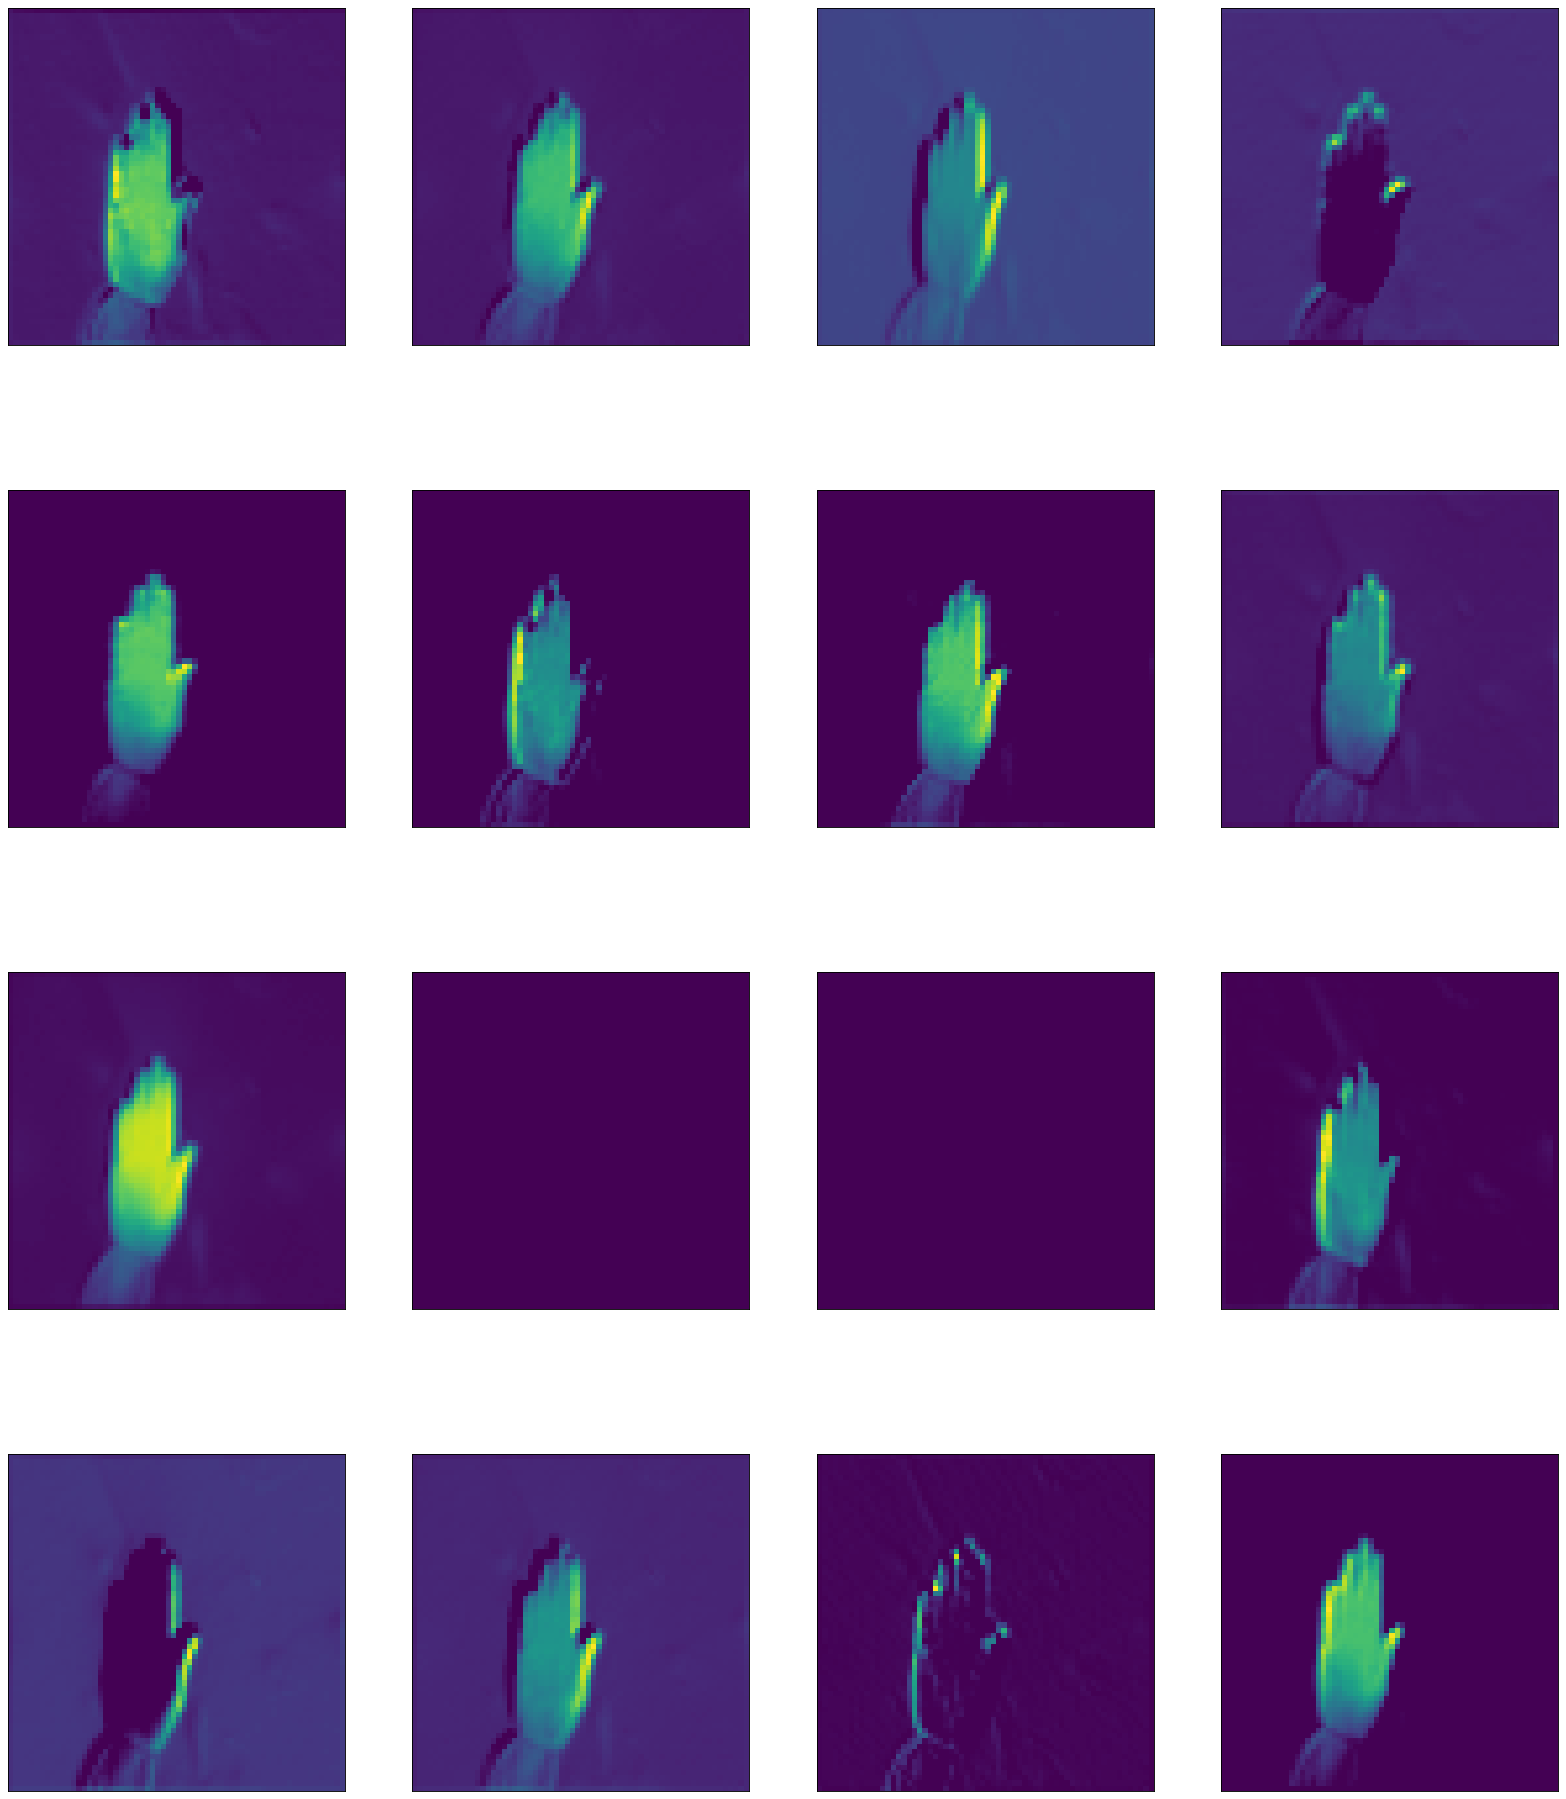

1/1 [==============================] - 0s 192ms/step


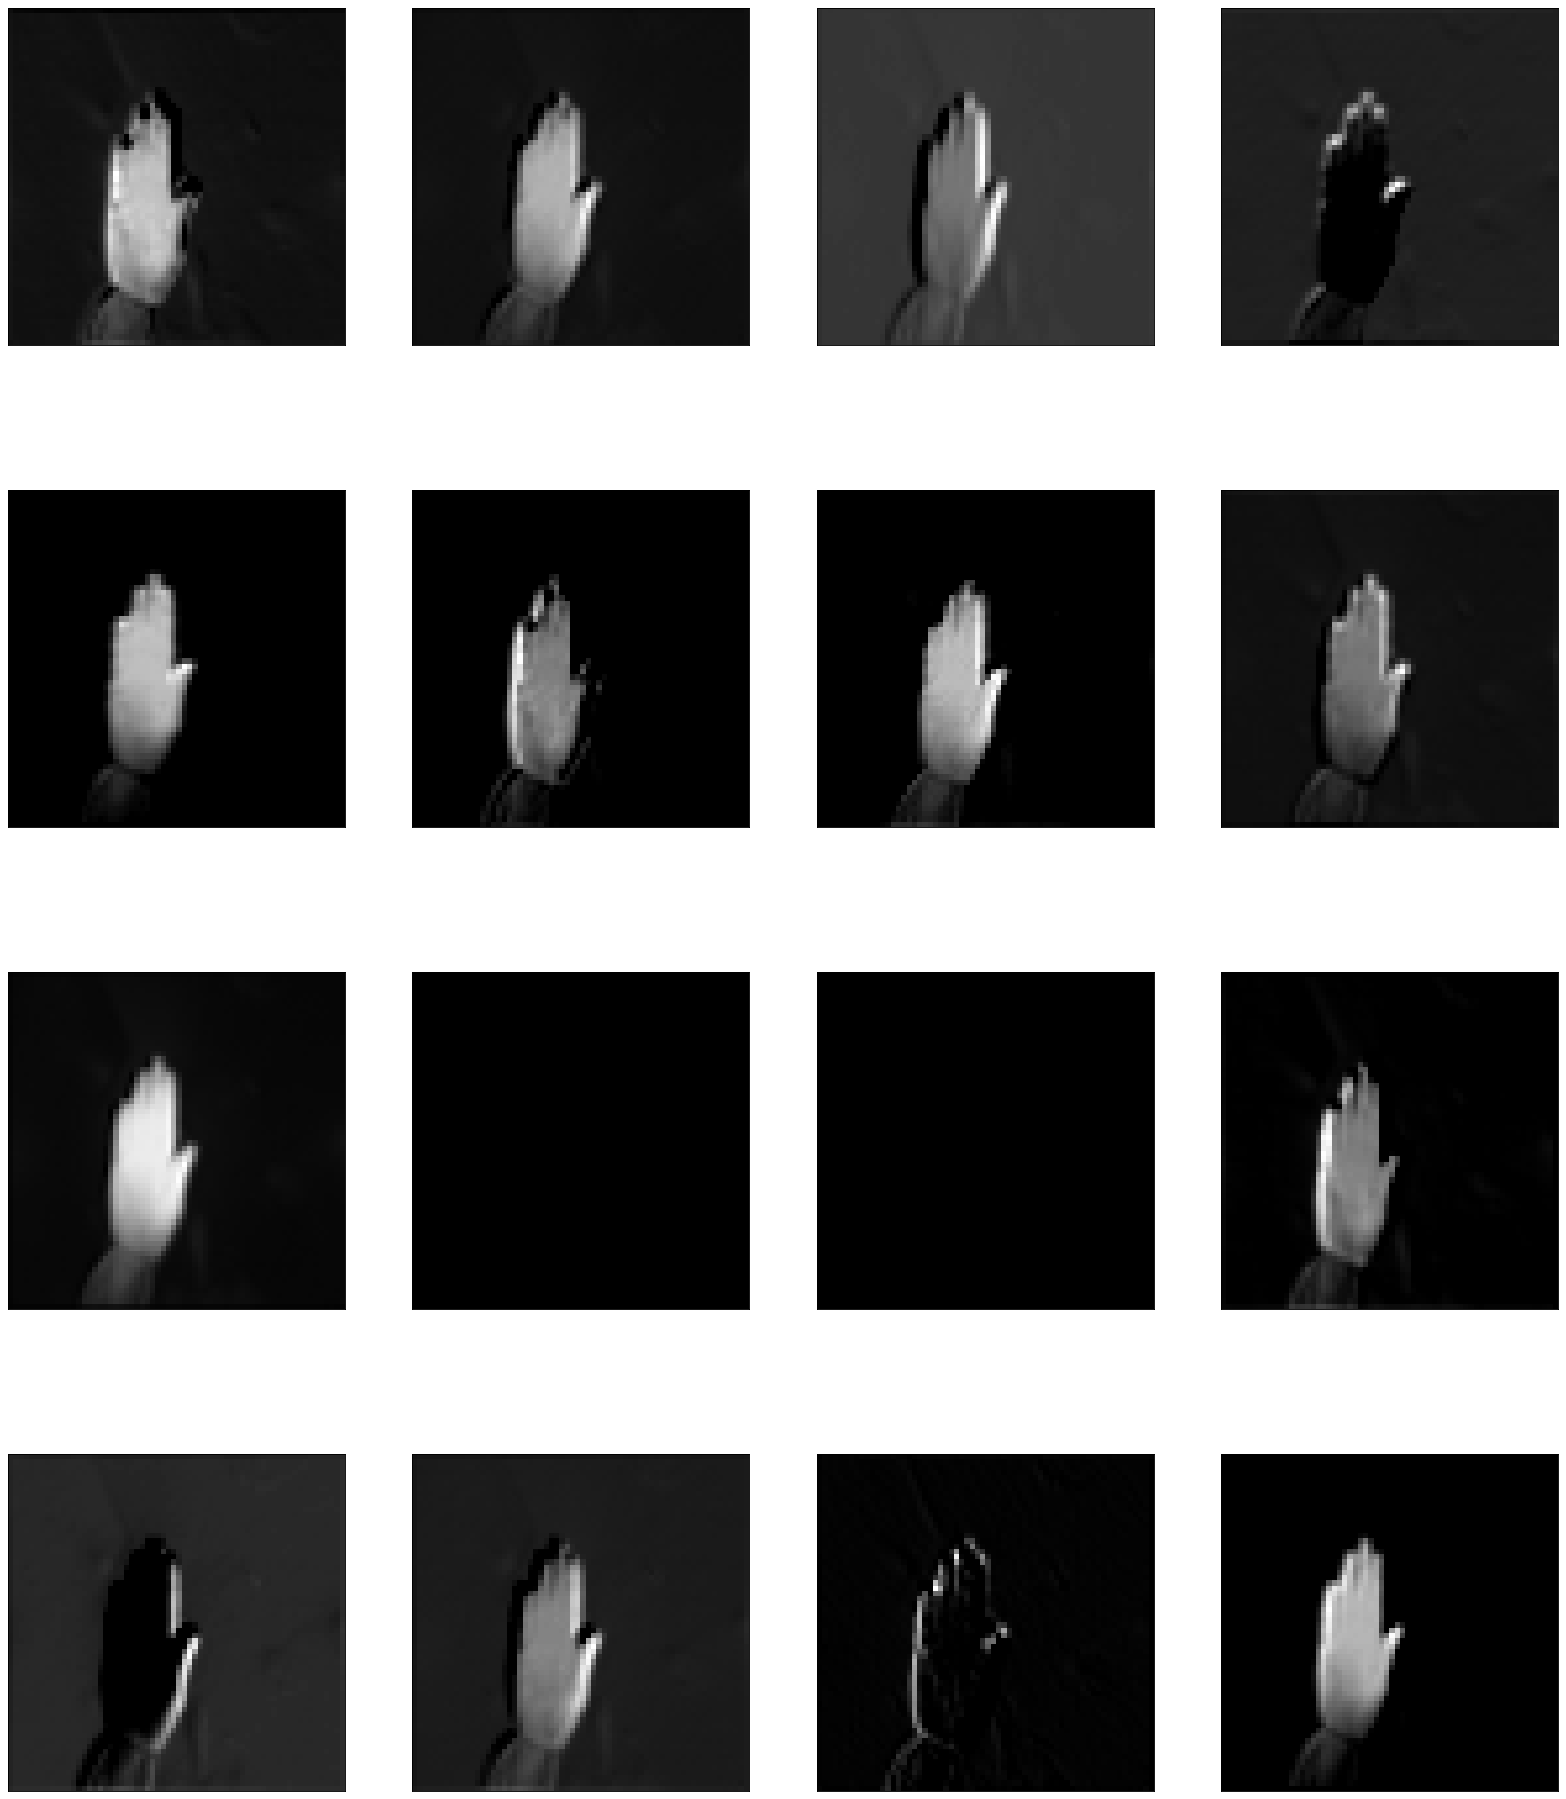

In [76]:
image_transform(X[66])
image_transform_gray(X[66])

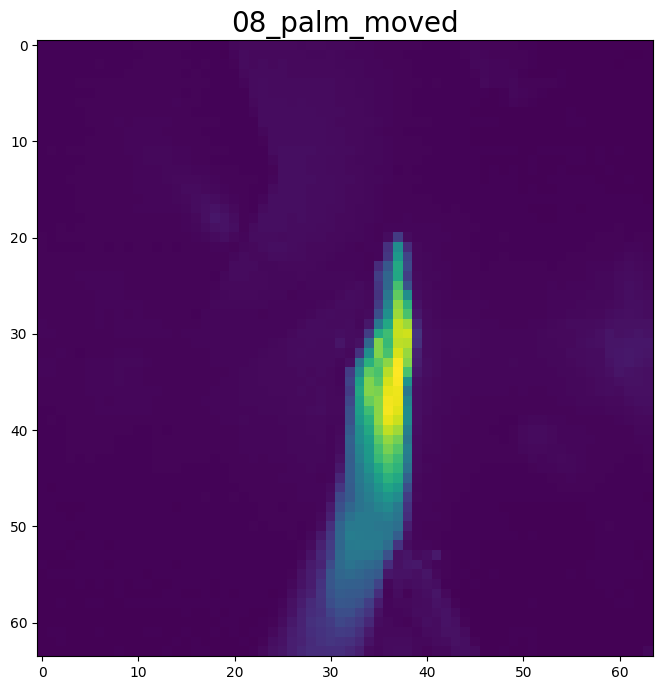

In [63]:
plt.figure(figsize=(25,8))
plt.imshow(X[56].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

1/1 [==============================] - 0s 130ms/step


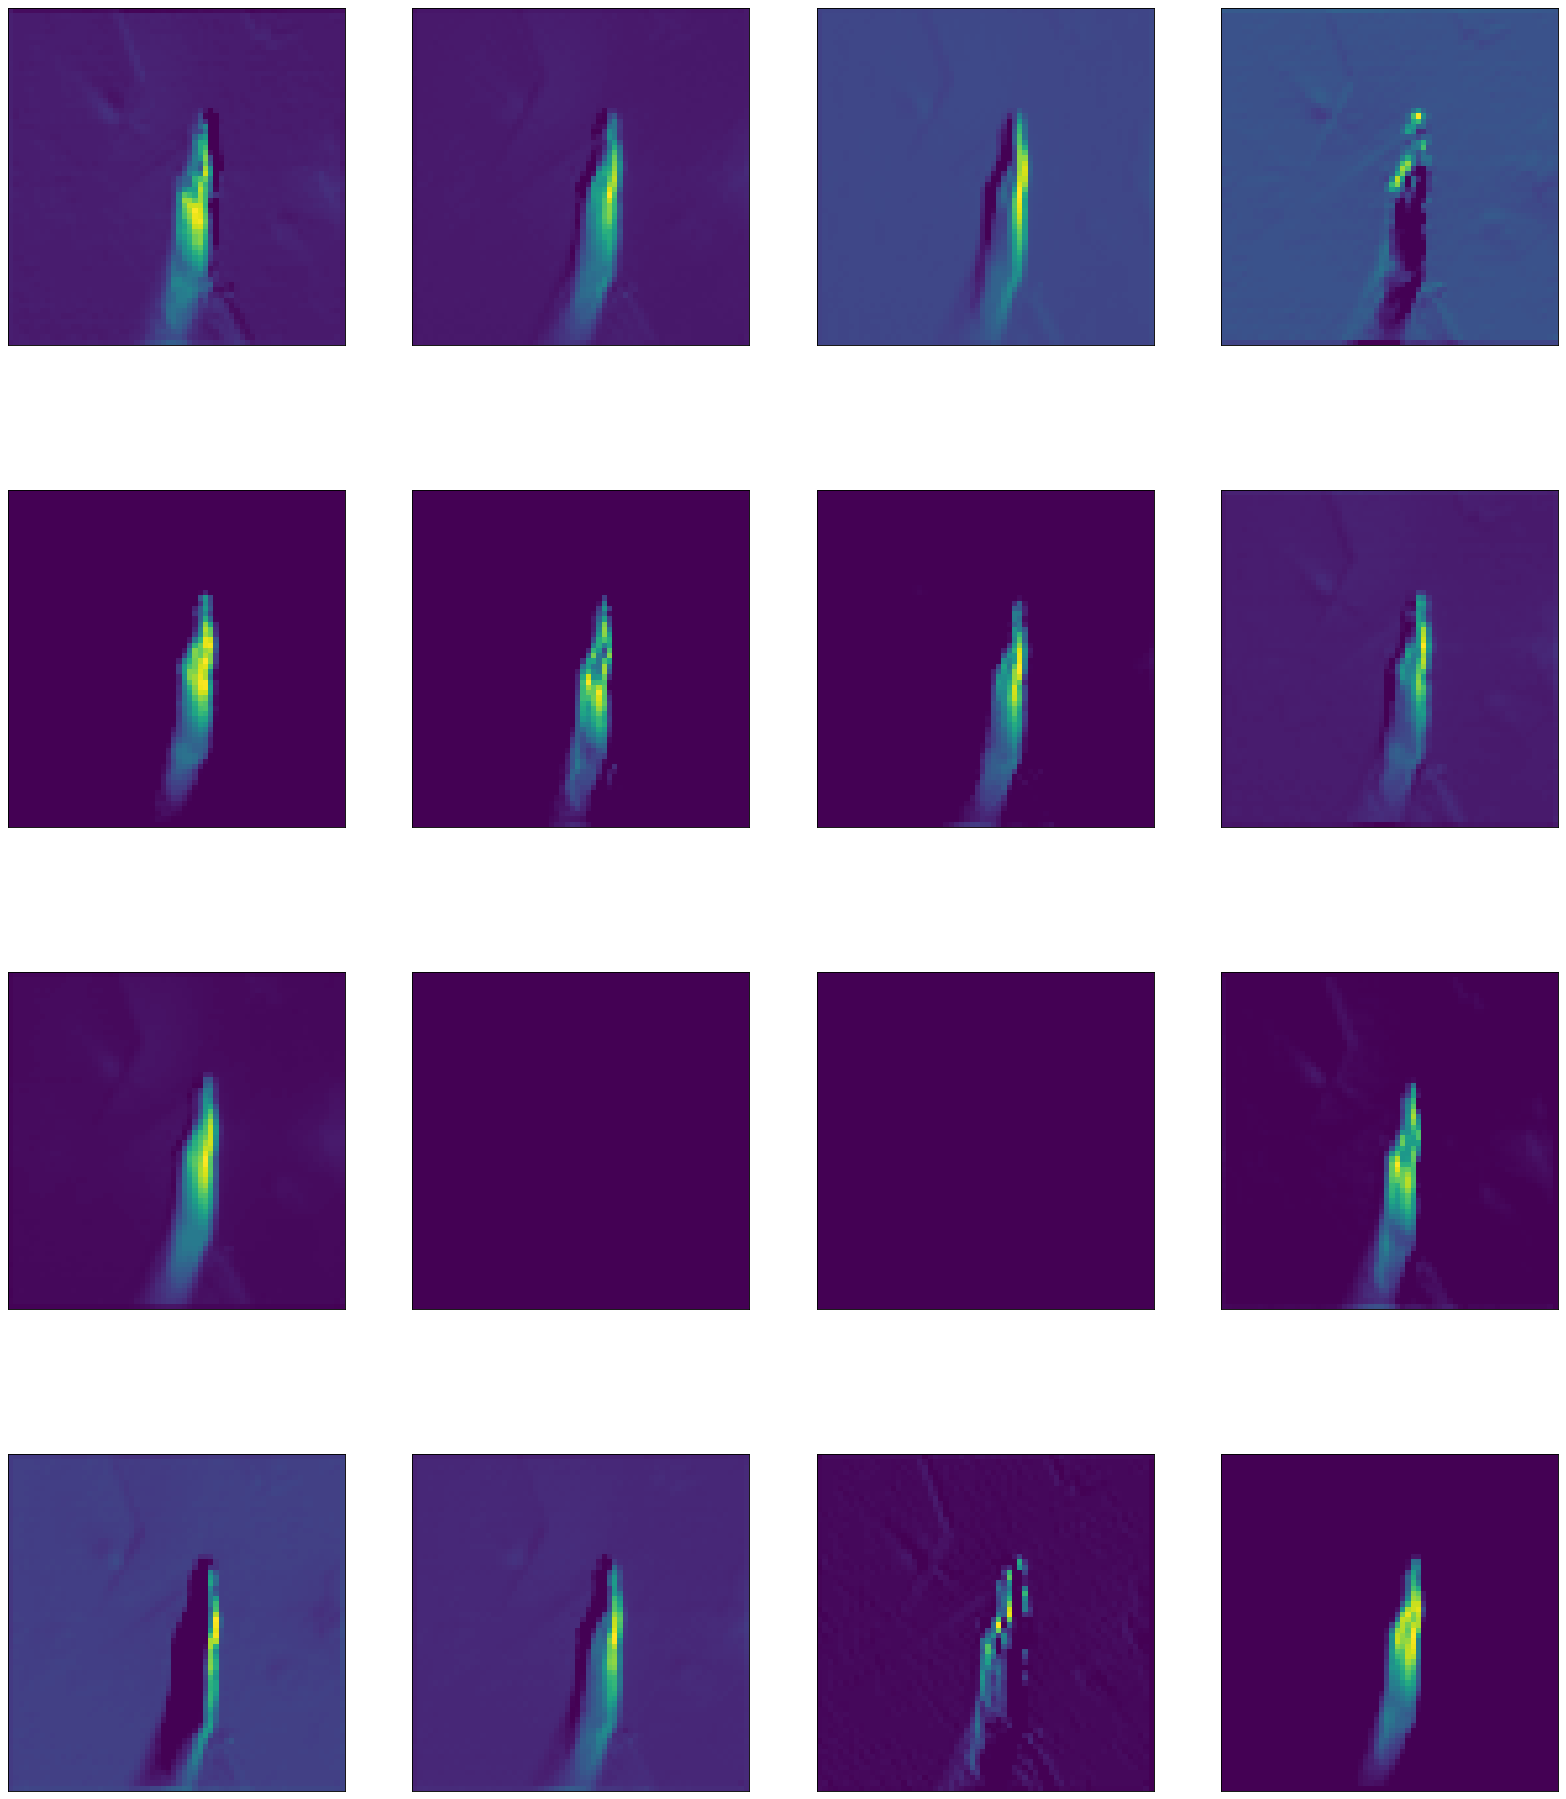

1/1 [==============================] - 0s 153ms/step


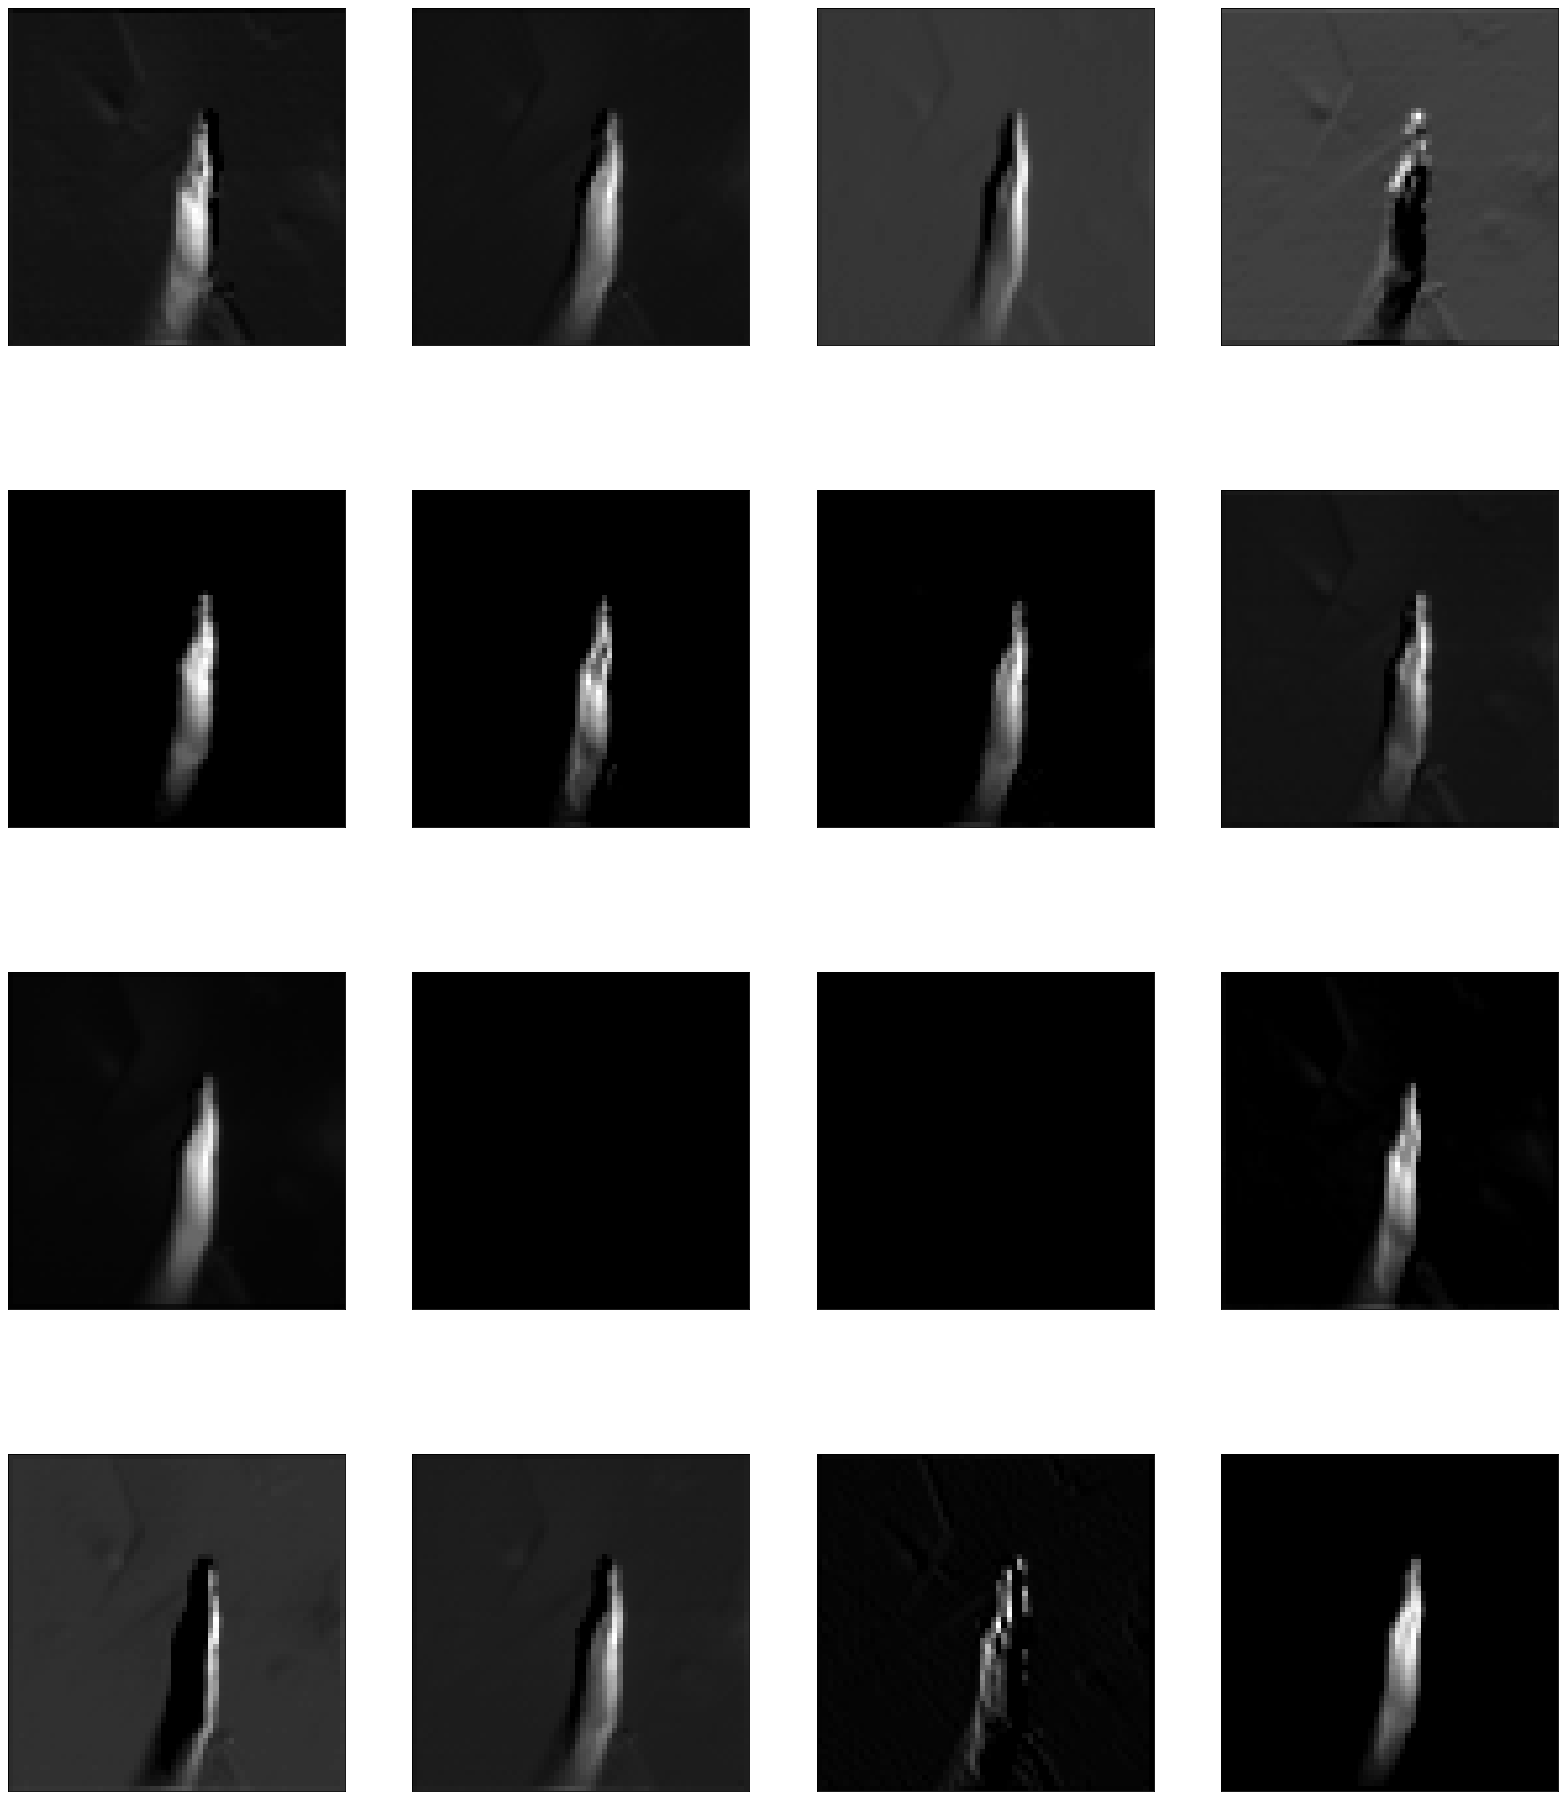

In [77]:
image_transform(X[56])
image_transform_gray(X[56])

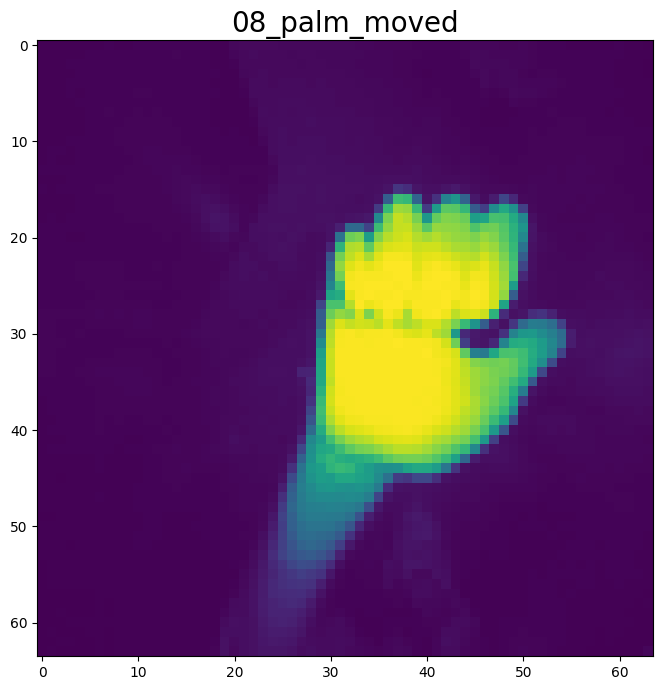

In [65]:
plt.figure(figsize=(25,8))
plt.imshow(X[1566].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,10))[0][0],size = 20)
plt.show()

1/1 [==============================] - 0s 82ms/step


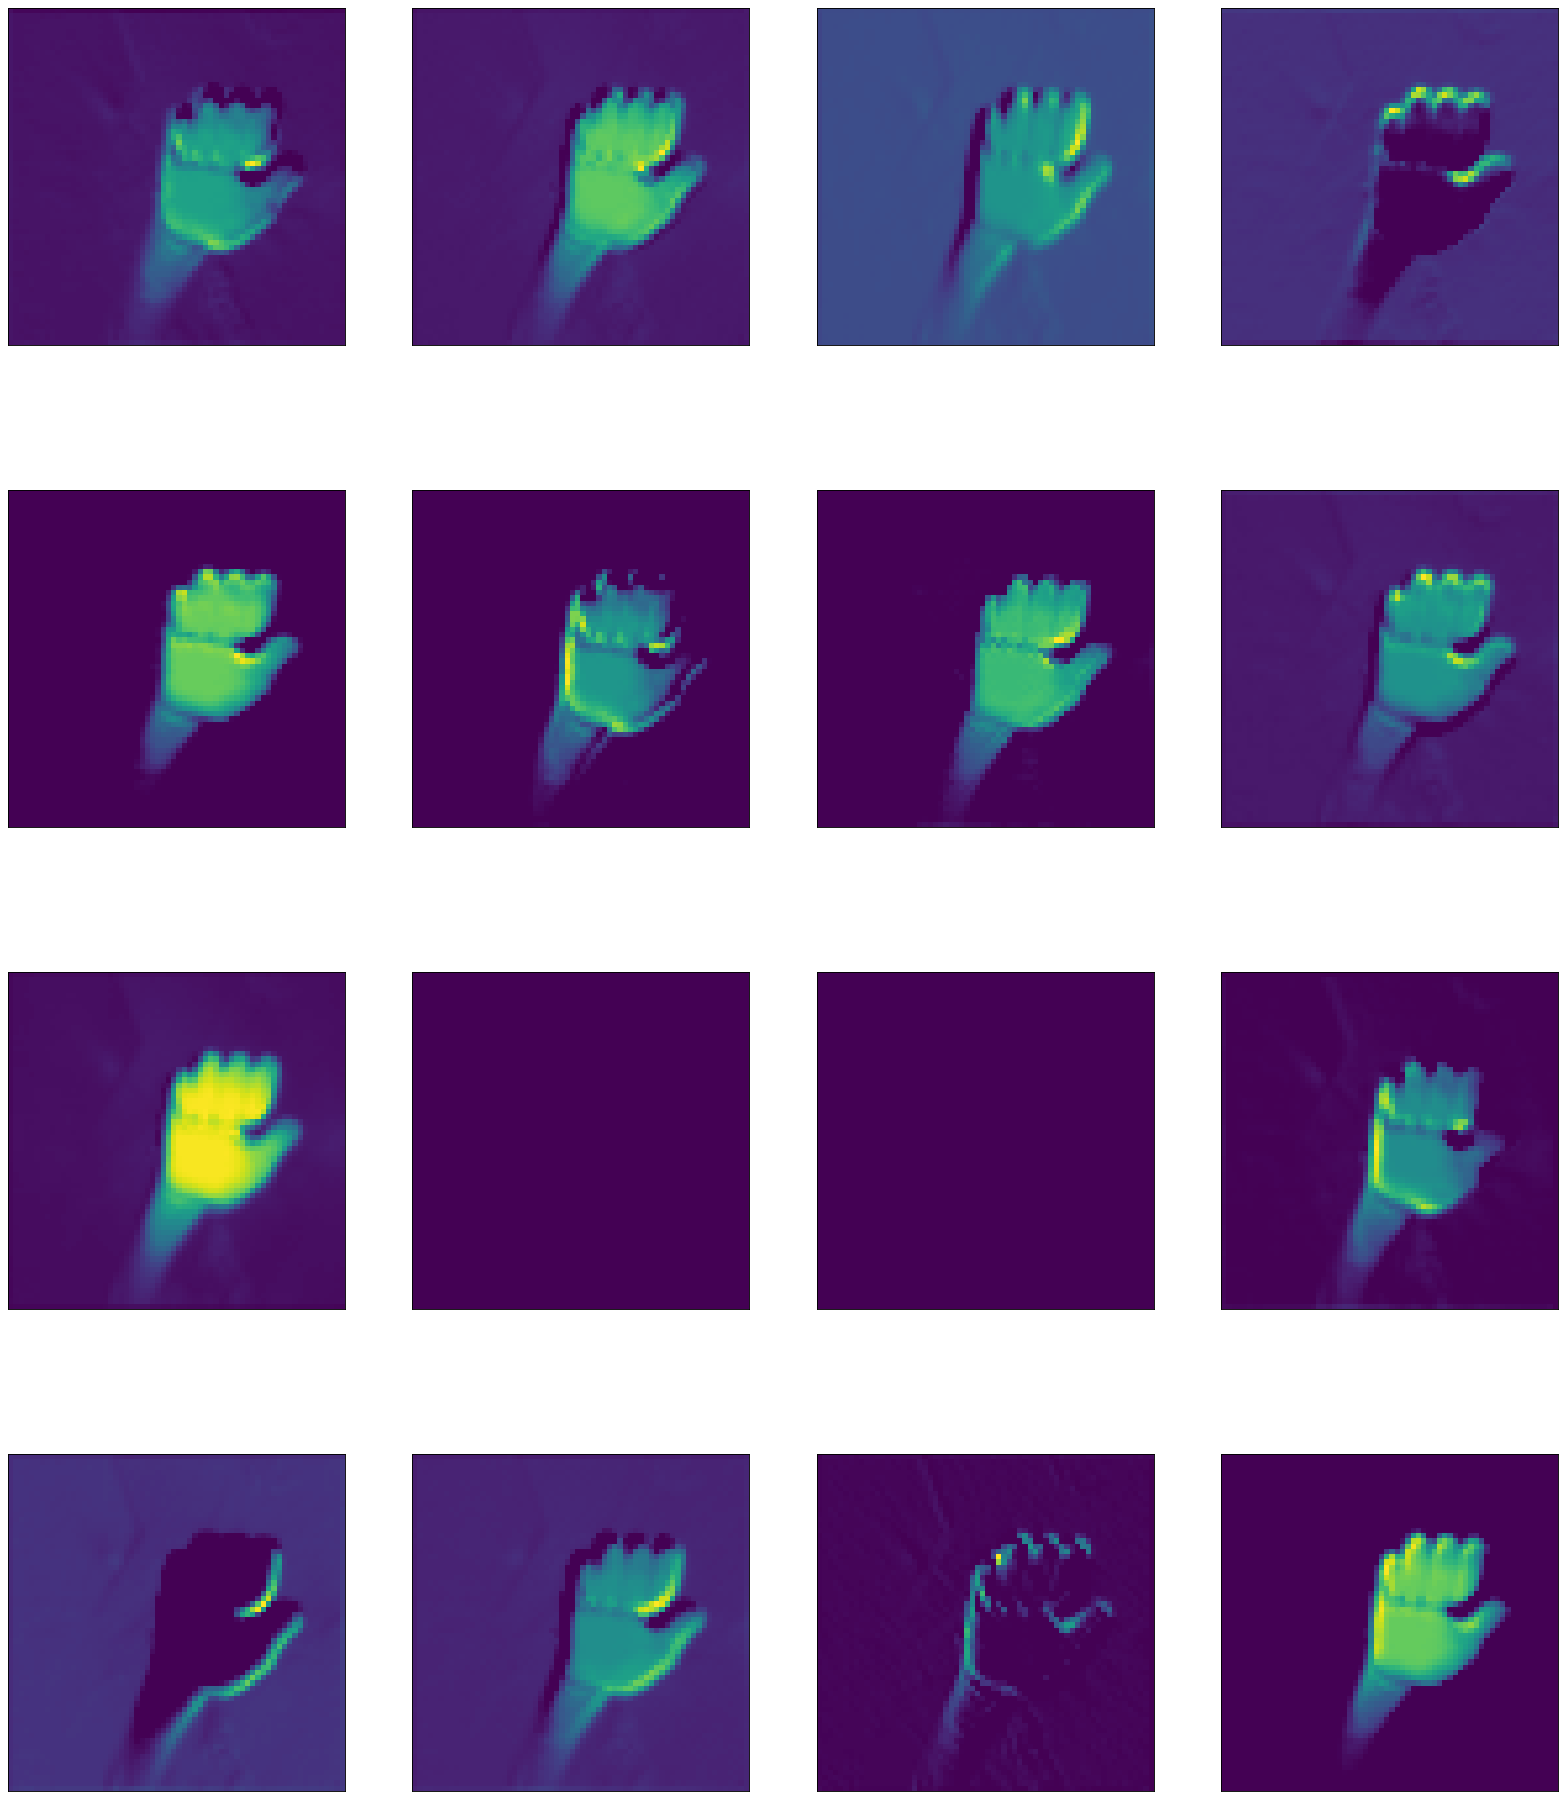

1/1 [==============================] - 0s 145ms/step


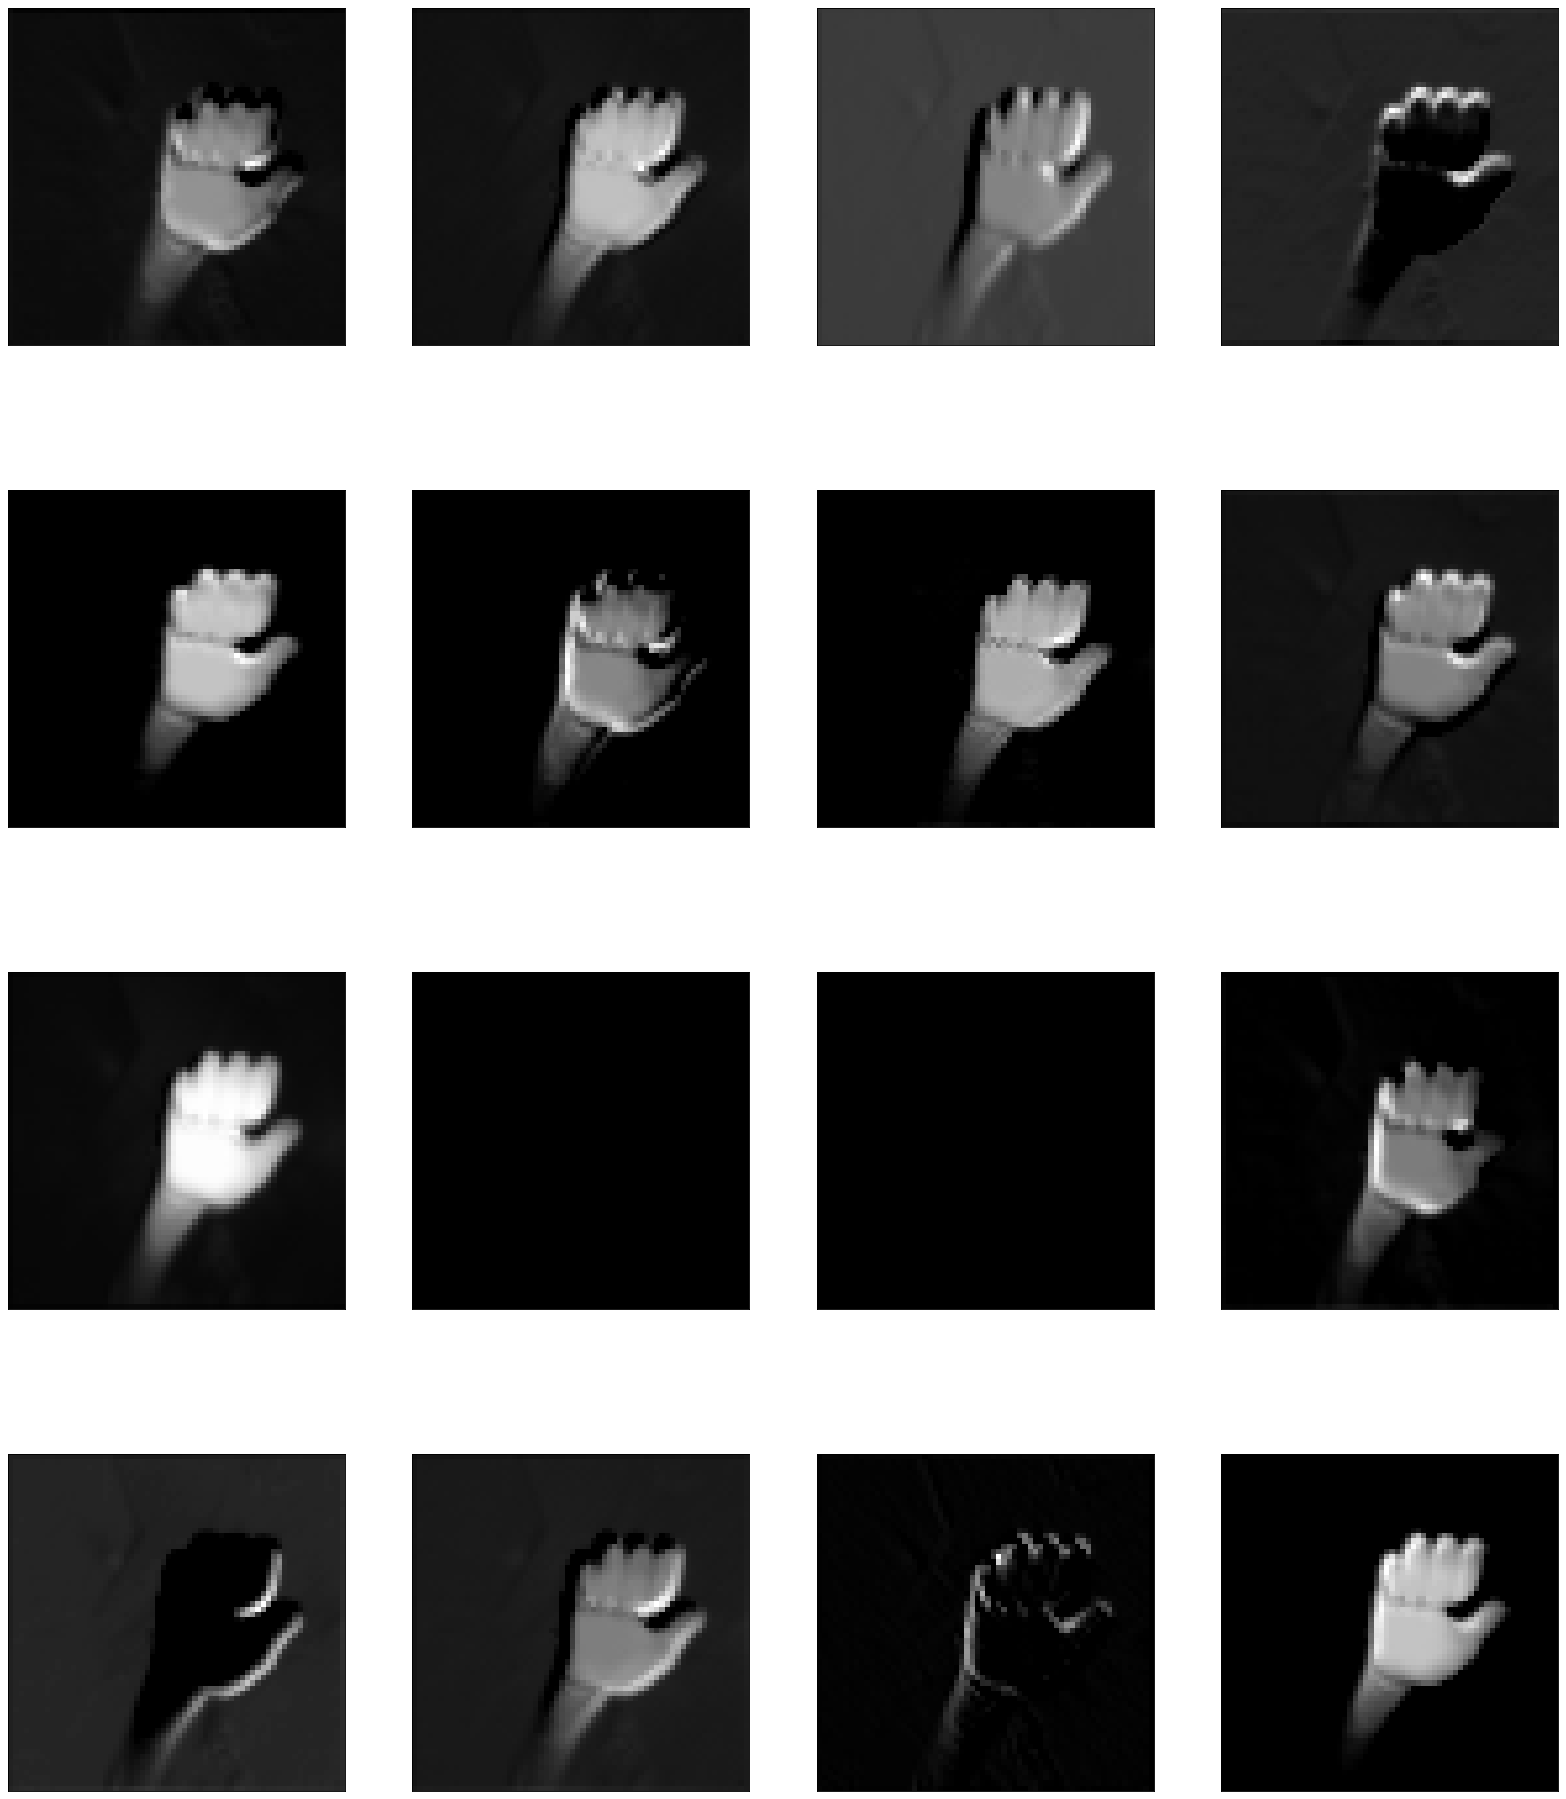

In [78]:
image_transform(X[1566])
image_transform_gray(X[1566])

# Test The Results

In [79]:
y_pred = model.evaluate(X_test , y_test,verbose =1)

63/63 [==============================] - 2s 27ms/step - loss: 3.8509e-06 - accuracy: 0.9995 - precision: 0.4731 - recall: 1.0000


In [80]:
y_pred[1]

0.9994999766349792

In [81]:
history.history['loss'][49]
import plotly.graph_objects as go


fig = go.Figure(data=[
    go.Bar(name = 'Accuracy',x=['Training','Validation','Real World Data'], y=[history.history['accuracy'][49] ,history.history['val_accuracy'][49],y_pred[1] ]),
    go.Bar(name = 'Precision',x=['Training','Validation','Real World Data'], y=[history.history['precision'][49] ,history.history['val_precision'][49],y_pred[2] ]),
    go.Bar(name = 'Loss',x=['Training','Validation','Real World Data'], y=[history.history['loss'][49] ,history.history['val_loss'][49],y_pred[0] ]),

])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(type = "log")
pyo.iplot(fig, filename = 'Act_train_rec')

In [82]:
model.predict(X_test)

63/63 [==============================] - 2s 32ms/step


array([[6.3204020e-02, 4.9694791e-04, 3.5682262e-03, ..., 2.0832364e-03,
        2.3812185e-01, 4.2905357e-02],
       [9.8371142e-01, 1.2230730e-02, 1.9637047e-01, ..., 3.5070980e-04,
        1.0000000e+00, 5.0835501e-02],
       [3.0314095e-02, 9.7087519e-03, 1.2779697e-03, ..., 1.3524939e-02,
        8.6837508e-02, 4.1240592e-02],
       ...,
       [1.0000000e+00, 8.1384508e-03, 1.8886767e-01, ..., 1.1219253e-02,
        5.3271800e-01, 3.1530551e-05],
       [3.4317657e-02, 1.7218745e-03, 2.5494190e-02, ..., 3.1593200e-04,
        2.6043220e-03, 4.3569828e-04],
       [9.8508877e-01, 2.9882526e-02, 9.7278017e-01, ..., 1.0000000e+00,
        9.5235246e-01, 1.1976919e-01]], dtype=float32)

In [83]:
y_prediction = model.predict(X_test)
def binary_classify(y_pred):
    for inp in y_pred:
        maximum = 0
        index = 0
        for i in range(10):
            if(maximum != max(maximum,inp[i])):
                maximum = max(maximum,inp[i])
                index = i
            inp[i] = 0
        inp[index]=1
    return y_pred
y_prediction  = binary_classify(y_prediction)

63/63 [==============================] - 2s 31ms/step


In [84]:
def create_result(y):
    y_final = []
    for i in range(y.shape[0]):
        y_final.append(enc.inverse_transform(y[i].reshape(1,10))[0][0])
    return y_final 
def remove_none(y , y_pred):
    index = []
    for i in range(len(y)-1,0,-1):
        if y_pred[i] == None :
            del y[i]
            del y_pred[i]
        
    return y , y_pred
def label_encode(y , y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_pred)
    print(le.classes_)
    y = le.transform(y)
    y_pred = le.transform(y_pred)
    return y , y_pred

y_class_result = create_result(y_prediction)
y_class_desired = create_result(y_test)

In [85]:
y_label_desired , y_label_result = label_encode(y_class_desired , y_class_result) 

['01_palm' '02_l' '03_fist' '04_fist_moved' '05_thumb' '06_index' '07_ok'
 '08_palm_moved' '09_c' '10_down']


In [86]:
from sklearn.metrics import classification_report
tn = []
for cat in enc.categories_[0].reshape(10,1):
    tn.append(cat[0])
target_names = tn
print(classification_report(y_label_desired, y_label_result, target_names=target_names))

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       205
         02_l       1.00      1.00      1.00       209
      03_fist       1.00      1.00      1.00       227
04_fist_moved       1.00      1.00      1.00       204
     05_thumb       1.00      1.00      1.00       175
     06_index       1.00      1.00      1.00       189
        07_ok       1.00      1.00      1.00       196
08_palm_moved       0.99      1.00      1.00       187
         09_c       1.00      0.99      1.00       200
      10_down       1.00      1.00      1.00       208

     accuracy                           1.00      2000
    macro avg       1.00      1.00      1.00      2000
 weighted avg       1.00      1.00      1.00      2000



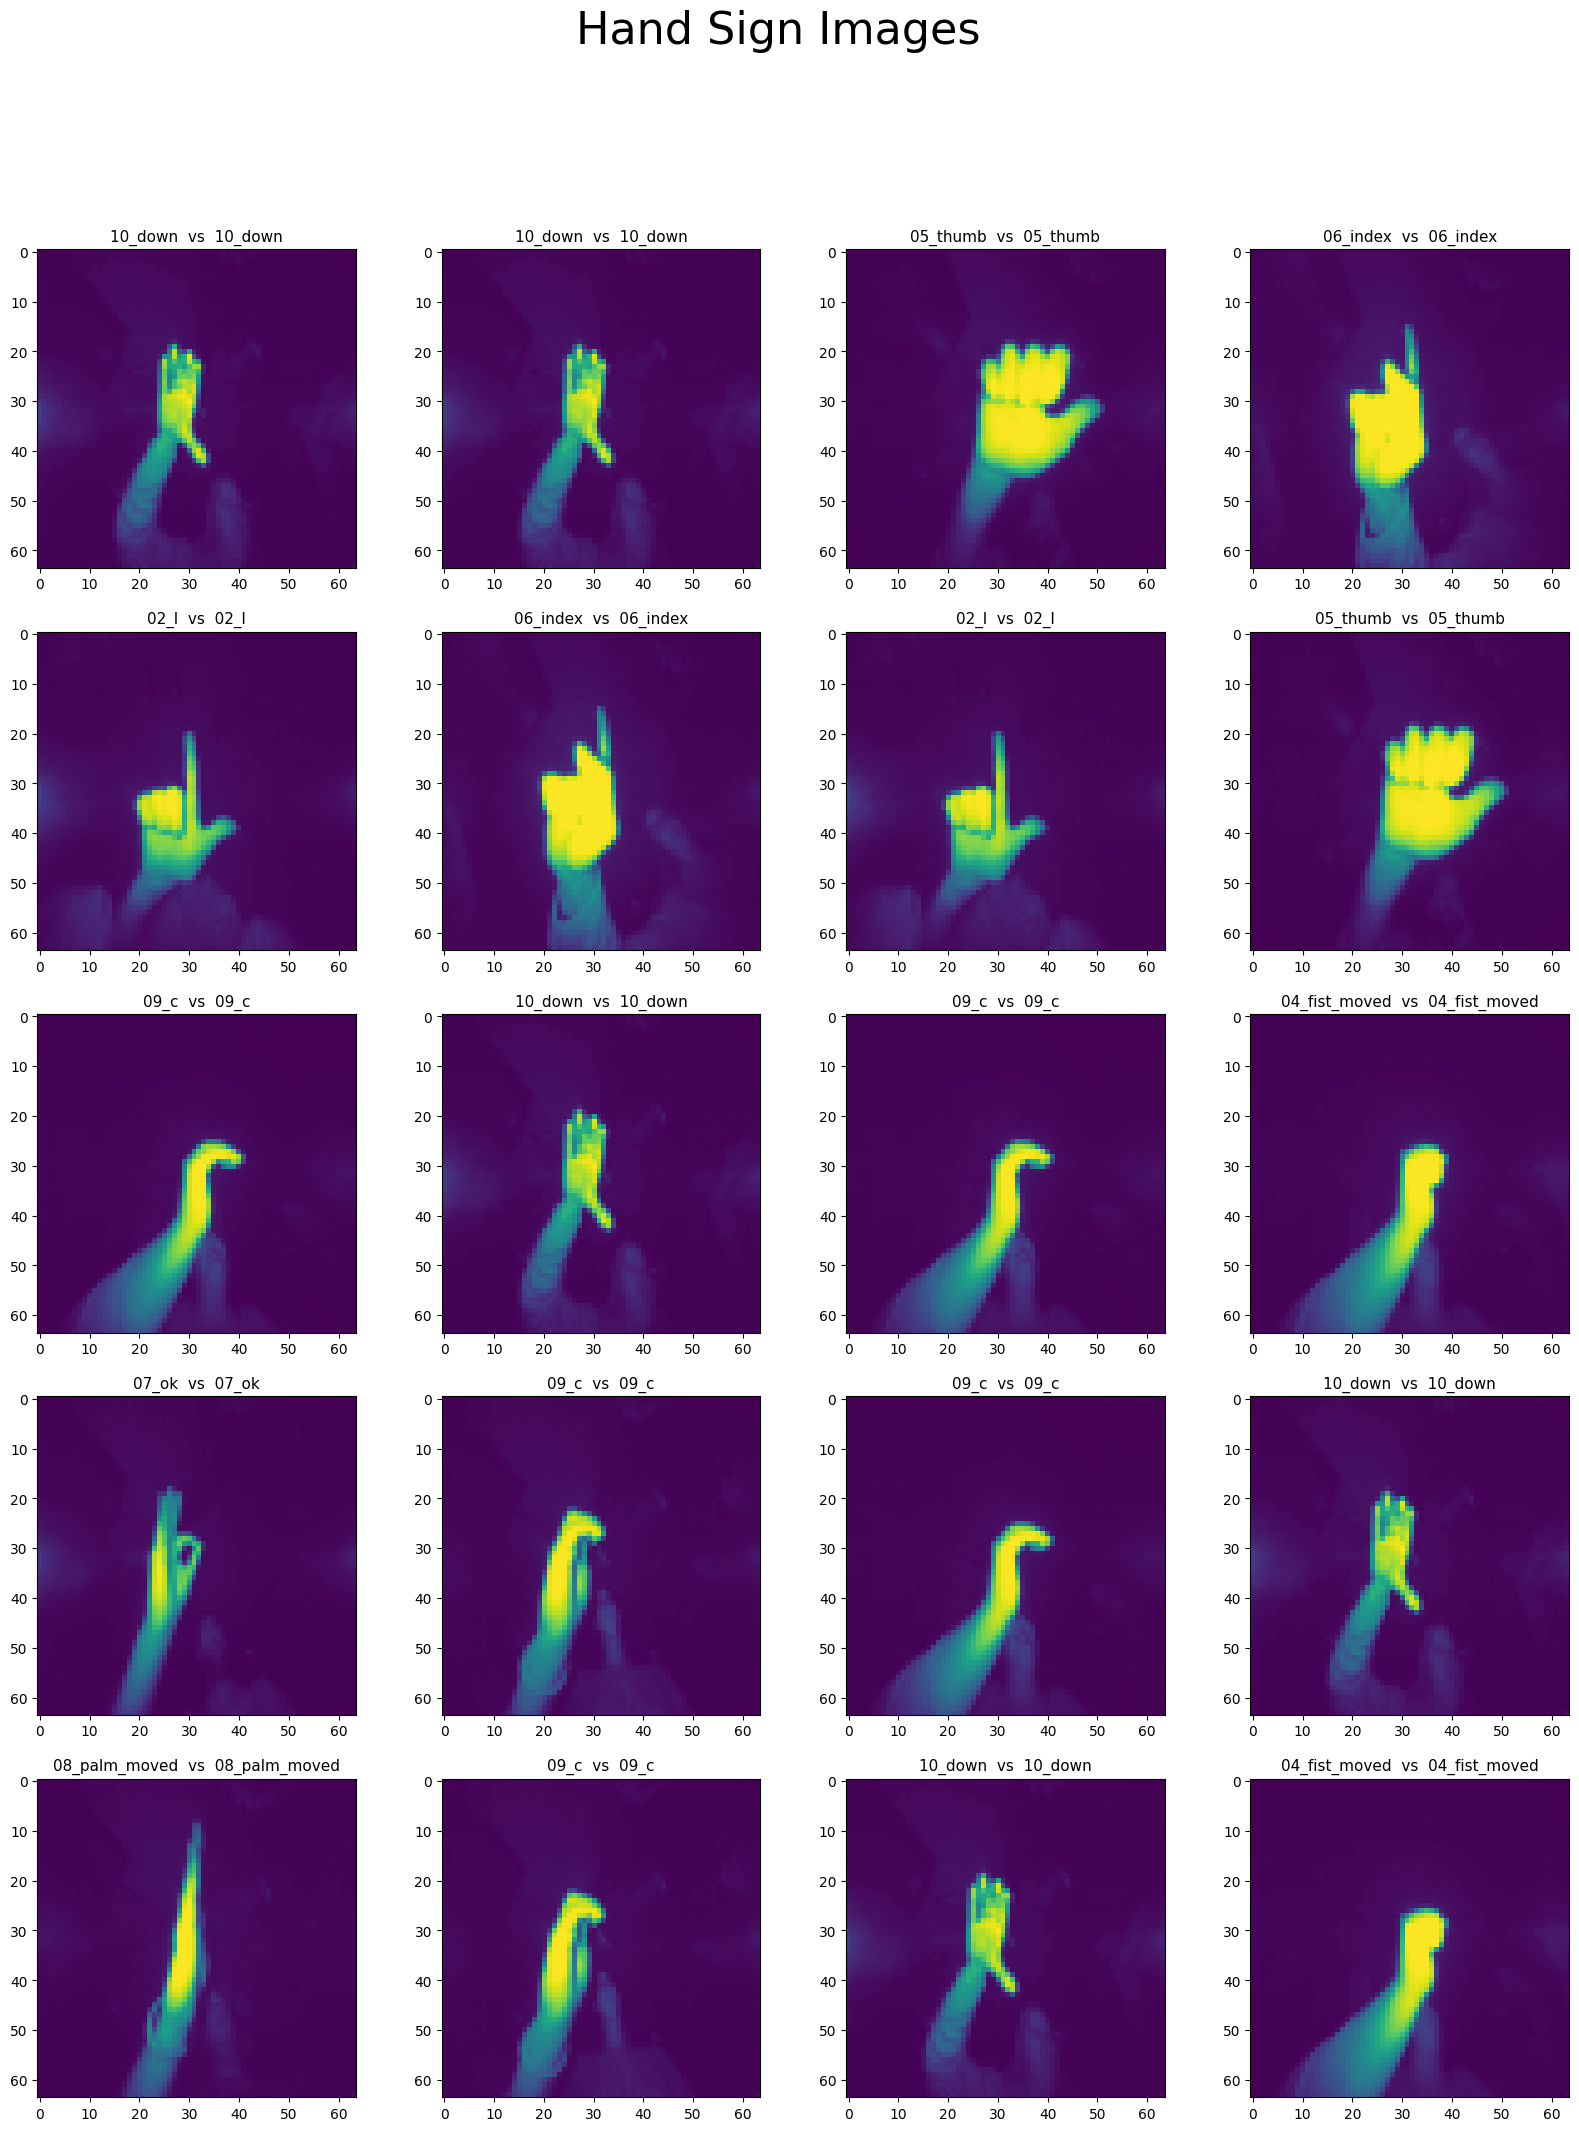

In [87]:
count = 1
f = plt.figure(figsize=(20,24))
for i in range(20):
    ind = random.sample(list(y_label_result),1)[0]
    img = X_test[ind]
    Class = str(y_class_desired[ind]) + '  vs  '+str(y_class_result[ind])
    ax = f.add_subplot(5, 4,count)
    ax = plt.imshow(img.reshape(w,h))
    ax = plt.title(Class,fontsize= 11)
    count = count + 1
plt.suptitle("Hand Sign Images", size = 32)
plt.show()